# Model predicting the number of shipments on a specific day

Contents of Input Databases:
* **DimDates** - Detailed information on dates. Each record in this database represents one day and contains various date-related attributes.
* **PostingVolume** - Daily shipment volumes from January 1, 2021, to August 31, 2023.
* **Clients_Orders** - Order forecasts provided by client X from the beginning of 2023. The data covers the upcoming month and is updated at the end of each preceding month.
* **Zadanie_Dane_Temperatura** - Daily meteorological measurements for two cities: Warsaw and Krakow. Data covers the period from January 2021 to August 2023.

# Table of Contents
1. [Initial Data Analysis](#wstępna_analiza)
    1. [DimDates](#wstępna_analiza_1)
    2. [PostingVolume](#wstępna_analiza_2)
    3. [Clients_Orders](#wstępna_analiza_3)
    4. [Temperature](#wstępna_analiza_4)
2. [Data Processing](#przetwarzanie_danych)
    1. [DimDates](#przetwarzanie_danych_1)
    2. [PostingVolume](#przetwarzanie_danych_2)
    3. [Clients_Orders](#przetwarzanie_danych_3)
    4. [Temperature](#przetwarzanie_danych_4)
3. [Data joining](#laczenie_danych)
4. [Exploratory Data Analysis](#eda)
    1. [Trends and seasonality in shipment data](#eda_1)
    2. [Analysis of the impact of client X forecasts on actual shipments](#eda_2)
    3. [Analysis of the impact of weather conditions on shipment volume](#eda_3)
5. [Modeling](#modelowanie)
6. [Evaluation and Conclusions](#ewaluacja)

In [1]:
import os
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV


from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, confusion_matrix, classification_report, accuracy_score

## 1.  Initial Data Analysis <a name="wstępna_analiza"></a>

Loading Data:

In [2]:
dim_dates_df=pd.read_csv('dimDates_Task.csv')
posting_volume_df=pd.read_parquet('Posting_Volumes', engine='fastparquet')
clients_orders_df = pd.read_excel('X_ClientORDERS.xlsx')

temperature_files = glob.glob(os.path.join('Zadanie_Dane_Temperatura', '*.csv'))
dfs = []
for file in temperature_files:
    df = pd.read_csv(file)
    dfs.append(df)
temperature_df = pd.concat(dfs, ignore_index=True)    

Helper Functions for Data Analysis:

In [3]:
def info(data):
    print("Info about the data frame:")
    display(data.info())
    
def head_and_tail(data):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    print("First and last rows of the data frame:")
    display(data.head(4))
    display(data.tail(4))
    
def shape(data):
    print('Number of rows and columns:')
    print(data.shape)
    
def statistics(data):
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_colwidth', None)
    pd.set_option('display.width', None)
    print("Descriptive statistic of the data frame:")
    display(data.describe(exclude=['object']))

In [4]:
def missing_values_statistic(data):
    missing_values_count = data.isnull().sum()

    missing_values_percent = (missing_values_count / len(data)) * 100

    missing_data = pd.DataFrame({
        'Missing values count': missing_values_count,
        'Percentage of missing data': missing_values_percent
    })

    display(missing_data)

### 1.1. DimDates <a name="wstępna_analiza_1"></a>

In [5]:
dim_dates_df.head()

datePk;dateId;dateYear;dateYearISO;dateMonthYear;dateWeekYearISO;dateQuarterYear;dateMonth;dateDay;dateDaySuffix;dateWeekDay;dateWeekDayName;dateWeekDayNameShort;dateWeekDayNameFirstLetter;dateDayOfYear;dateWeekOfMonth;dateWeekOfYear;dateWeekOfYearISO;dateMonthName;dateMonthNameShort;dateMonthNameFirstLetter;dateQuarter;dateQuarterName;dateQuarterShort;dateIsWeekend;dateIsHolidayInd;dateWeekDayStartsMonday;dateWeekDayNamePL;dateMonthNamePL;dateWeekOfYearStartsMonday;firstDayWorkBefore;firstDayWorkAfter;firstDayNoHolidayNoSaturdayAfter;firstDayNoHolidayNoSundayAfter;firstDayNoHolidayNoSaturdayAfterData;firstDayNoSaturdayNoHolidayOrSundayHolidayName;firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday;firstDayNoSaturdayNoHolidayOrSundayHoliday;isThuHolyday;isFriHolyday;isSatHolyday;isWeekendParcelServiceBreakInd;courierBillingPeriodDateFk;courierBillingPeriodStartDateFk;courierBillingPeriodEndDateFk;xlsDate;dwhDateFrom;dwhDateTo;dwhCurrRec;dwhAuditCd;dwhAuditCp;dwhAuditMd;dwhAuditMp
0  20201004;2020-10-04;2020;2020;10.2020;T40-2020...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
1  20200810;2020-08-10;2020;2020;08.2020;T33-2020...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
2  20200930;2020-09-30;2020;2020;09.2020;T40-2020...                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
3  20200521;20

In [6]:
dim_dates_df = pd.read_csv('dimDates_Task.csv', delimiter=';')

In [7]:
head_and_tail(dim_dates_df)

First and last rows of the data frame:


datePk      dateId  dateYear  dateYearISO  dateMonthYear dateWeekYearISO  \
0  20201004  2020-10-04      2020         2020         10.202        T40-2020   
1  20200810  2020-08-10      2020         2020          8.202        T33-2020   
2  20200930  2020-09-30      2020         2020          9.202        T40-2020   
3  20200521  2020-05-21      2020         2020          5.202        T21-2020   

  dateQuarterYear  dateMonth  dateDay dateDaySuffix  dateWeekDay  \
0         Q4-2020         10        4            th            1   
1         Q3-2020          8       10            th            2   
2         Q3-2020          9       30            th            4   
3         Q2-2020          5       21            st            5   

  dateWeekDayName dateWeekDayNameShort dateWeekDayNameFirstLetter  \
0          Sunday                  SUN                          S   
1          Monday                  MON                          M   
2       Wednesday                  WED                          W   
3        Thursday                  THU                          T   

   dateDayOfYear  dateWeekOfMonth  dateWeekOfYear  dateWeekOfYearISO  \
0            278                2              41                 40   
1            223                3              33                 33   
2            274                5              40                 40   
3            142                4              21                 21   

  dateMonthName dateMonthNameShort dateMonthNameFirstLetter  dateQuarter  \
0       October                OCT                        O            4   
1        August                AUG                        A            3   
2     September                SEP                        S            3   
3           May                MAY                        M            2   

  dateQuarterName dateQuarterShort  dateIsWeekend  dateIsHolidayInd  \
0          Fourth            Qtr 4              1                 0   
1           Third            Qtr 3              0                 0   
2           Third            Qtr 3              0                 0   
3          Second            Qtr 2              0                 0   

   dateWeekDayStartsMonday dateWeekDayNamePL dateMonthNamePL  \
0                        7         Niedziela     Październik   
1                        1      Poniedziałek        Sierpień   
2                        3             Środa        Wrzesień   
3                        4          Czwartek             Maj   

   dateWeekOfYearStartsMonday  firstDayWorkBefore  firstDayWorkAfter  \
0                          40            20201002           20201005   
1                          33            20200807           20200811   
2                          40            20200929           20201001   
3                          21            20200520           20200522   

   firstDayNoHolidayNoSaturdayAfter  firstDayNoHolidayNoSundayAfter  \
0                          20201005                        20201005   
1                          20200811                        20200811   
2                          20201001                        20201001   
3                          20200522                        20200522   

   firstDayNoHolidayNoSaturdayAfterData  \
0                              20201005   
1                              20200811   
2                              20201001   
3                              20200522   

  firstDayNoSaturdayNoHolidayOrSundayHolidayName  \
0                                            MON   
1                                            TUE   
2                                            THU   
3                                            FRI   

   firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday  \
0                                                    0   
1                                                    0   
2                                                    0   
3                                                    0   

   first

datePk      dateId  dateYear  dateYearISO  dateMonthYear  \
1457  20200417  2020-04-17      2020         2020         4.2020   
1458  20201104  2020-11-04      2020         2020        11.2020   
1459  20201116  2020-11-16      2020         2020        11.2020   
1460  20210117  2021-01-17      2021         2021         1.2021   

     dateWeekYearISO dateQuarterYear  dateMonth  dateDay dateDaySuffix  \
1457        T16-2020         Q2-2020          4       17            th   
1458        T45-2020         Q4-2020         11        4            th   
1459        T47-2020         Q4-2020         11       16            th   
1460         T2-2021         Q1-2021          1       17            th   

      dateWeekDay dateWeekDayName dateWeekDayNameShort  \
1457            6          Friday                  FRI   
1458            4       Wednesday                  WED   
1459            2          Monday                  MON   
1460            1          Sunday                  SUN   

     dateWeekDayNameFirstLetter  dateDayOfYear  dateWeekOfMonth  \
1457                          F            108                3   
1458                          W            309                1   
1459                          M            321                3   
1460                          S             17                4   

      dateWeekOfYear  dateWeekOfYearISO dateMonthName dateMonthNameShort  \
1457              16                 16         April                APR   
1458              45                 45      November                NOV   
1459              47                 47      November                NOV   
1460               4                  2       January                JAN   

     dateMonthNameFirstLetter  dateQuarter dateQuarterName dateQuarterShort  \
1457                        A            2          Second            Qtr 2   
1458                        N            4          Fourth            Qtr 4   
1459                        N            4          Fourth            Qtr 4   
1460                        J            1           First            Qtr 1   

      dateIsWeekend  dateIsHolidayInd  dateWeekDayStartsMonday  \
1457              0                 0                        5   
1458              0                 0                        3   
1459              0                 0                        1   
1460              1                 0                        7   

     dateWeekDayNamePL dateMonthNamePL  dateWeekOfYearStartsMonday  \
1457            Piątek        Kwiecień                          16   
1458             Środa        Listopad                          45   
1459      Poniedziałek        Listopad                          47   
1460         Niedziela         Styczeń                           3   

      firstDayWorkBefore  firstDayWorkAfter  firstDayNoHolidayNoSaturdayAfter  \
1457            20200416           20200420                          20200419   
1458            20201103           20201105                          20201105   
1459            20201113           20201117                          20201117   
1460            20210115           20210118                          20210118   

      firstDayNoHolidayNoSundayAfter  firstDayNoHolidayNoSaturdayAfterData  \
1457                        20200418                              20200419   
1458                        20201105                              20201105   
1459                        20201117                              20201117   
1460                        20210118                              20210118   

     firstDayNoSaturdayNoHolidayOrSundayHolidayName  \
1457                                            SUN   
1458                                            THU   
1459                                            TUE   
1460                                            MON   

      firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday  \
1457                                                    0   
1458           

In [8]:
shape(dim_dates_df)

Number of rows and columns:
(1461, 53)


In [9]:
info(dim_dates_df)

Info about the data frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 53 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   datePk                                               1461 non-null   int64  
 1   dateId                                               1461 non-null   object 
 2   dateYear                                             1461 non-null   int64  
 3   dateYearISO                                          1461 non-null   int64  
 4   dateMonthYear                                        1461 non-null   float64
 5   dateWeekYearISO                                      1461 non-null   object 
 6   dateQuarterYear                                      1461 non-null   object 
 7   dateMonth                                            1461 non-null   int64  
 8   dateDay                                  

None

In [10]:
statistics(dim_dates_df)

Descriptive statistic of the data frame:


datePk     dateYear  dateYearISO  dateMonthYear    dateMonth  \
count  1.461000e+03  1461.000000  1461.000000    1461.000000  1461.000000   
mean   2.021566e+07  2021.498973  2021.494867       6.725079     6.522930   
std    1.119295e+04     1.118723     1.119935       3.449884     3.449884   
min    2.020010e+07  2020.000000  2020.000000       1.202000     1.000000   
25%    2.020123e+07  2020.000000  2020.000000       4.202000     4.000000   
50%    2.021123e+07  2021.000000  2021.000000       7.202000     7.000000   
75%    2.022123e+07  2022.000000  2022.000000      10.202000    10.000000   
max    2.023123e+07  2023.000000  2023.000000      12.202300    12.000000   

           dateDay  dateWeekDay  dateDayOfYear  dateWeekOfMonth  \
count  1461.000000  1461.000000    1461.000000      1461.000000   
mean     15.729637     4.002053     183.125257         3.116359   
std       8.803105     2.001197     105.474746         1.320082   
min       1.000000     1.000000       1.000000         1.000000   
25%       8.000000     2.000000      92.000000         2.000000   
50%      16.000000     4.000000     183.000000         3.000000   
75%      23.000000     6.000000     274.000000         4.000000   
max      31.000000     7.000000     366.000000         6.000000   

       dateWeekOfYear  dateWeekOfYearISO  dateQuarter  dateIsWeekend  \
count     1461.000000        1461.000000  1461.000000    1461.000000   
mean        27.088980          26.661875     2.508556       0.286105   
std         15.072801          15.069269     1.117465       0.452094   
min          1.000000           1.000000     1.000000       0.000000   
25%         14.000000          14.000000     2.000000       0.000000   
50%         27.000000          27.000000     3.000000       0.000000   
75%         40.000000          40.000000     4.000000       1.000000   
max         53.000000          53.000000     4.000000       1.000000   

       dateIsHolidayInd  dateWeekDayStartsMonday  dateWeekOfYearStartsMonday  \
count       1461.000000              1461.000000                 1461.000000   
mean           0.038330                 4.003422                   27.195756   
std            0.192057                 1.999826                   15.071792   
min            0.000000                 1.000000                    1.000000   
25%            0.000000                 2.000000                   14.000000   
50%            0.000000                 4.000000                   27.000000   
75%            0.000000                 6.000000                   40.000000   
max            1.000000                 7.000000                   53.000000   

       firstDayWorkBefore  firstDayWorkAfter  \
count        1.461000e+03       1.461000e+03   
mean         2.021559e+07       2.021572e+07   
std          1.122535e+04       1.122521e+04   
min          2.019123e+07       2.020010e+07   
25%          2.020123e+07       2.021010e+07   
50%          2.021123e+07       2.022010e+07   
75%          2.022123e+07       2.023010e+07   
max          2.023123e+07       2.024010e+07   

       firstDayNoHolidayNoSaturdayAfter  firstDayNoHolidayNoSundayAfter  \
count                      1.461000e+03                    1.461000e+03   
mean                       2.021570e+07                    2.021570e+07   
std                        1.120355e+04                    1.120912e+04   
min                        2.020010e+07                    2.020010e+07   
25%                        2.021010e+07                    2.021010e+07   
50%                        2.022010e+07                    2.022010e+07   
75%                        2.023010e+07                    2.023010e+07   
max                        2.024010e+07                    2.024010e+07   

       firstDayNoHolidayNoSaturdayAfterData  \
count                          1.461000e+03   
mean                           2.021570e+07   
std                            1.120934e+04   
min                            2.020010e+07   
2

In [11]:
object_columns = [
    'dateId', 'dateDaySuffix', 'dateWeekDayName', 'dateWeekDayNameShort', 
    'dateWeekDayNameFirstLetter', 'dateMonthName', 'dateMonthNameShort', 
    'dateMonthNameFirstLetter', 'dateQuarterName', 'dateQuarterShort', 
    'dateWeekDayNamePL', 'dateMonthNamePL', 'firstDayNoSaturdayNoHolidayOrSundayHolidayName'
]

for column in object_columns:
    unique_values = dim_dates_df[column].unique()
    print(f"Unique values in column '{column}':")
    print(unique_values)
    print("\n")

Unique values in column 'dateId':
['2020-10-04' '2020-08-10' '2020-09-30' ... '2020-11-04' '2020-11-16'
 '2021-01-17']


Unique values in column 'dateDaySuffix':
['th' 'st' 'rd' 'nd']


Unique values in column 'dateWeekDayName':
['Sunday' 'Monday' 'Wednesday' 'Thursday' 'Saturday' 'Tuesday' 'Friday']


Unique values in column 'dateWeekDayNameShort':
['SUN' 'MON' 'WED' 'THU' 'SAT' 'TUE' 'FRI']


Unique values in column 'dateWeekDayNameFirstLetter':
['S' 'M' 'W' 'T' 'F']


Unique values in column 'dateMonthName':
['October' 'August' 'September' 'May' 'June' 'February' 'November' 'March'
 'April' 'January' 'December' 'July']


Unique values in column 'dateMonthNameShort':
['OCT' 'AUG' 'SEP' 'MAY' 'JUN' 'FEB' 'NOV' 'MAR' 'APR' 'JAN' 'DEC' 'JUL']


Unique values in column 'dateMonthNameFirstLetter':
['O' 'A' 'S' 'M' 'J' 'F' 'N' 'D']


Unique values in column 'dateQuarterName':
['Fourth' 'Third' 'Second' 'First']


Unique values in column 'dateQuarterShort':
['Qtr 4' 'Qtr 3' 'Qtr 2' 'Qtr 1']

#### Conclusion:
Columns containing **object** data do not contain incorrect (incorrectly written or inconsistent with reality) data.

#### Column description:

1. **datePk**: Unique date identifier in numeric format (Primary key).
2. **dateId**: Date in ISO format (YYYY-MM-DD).
3. **dateYear**: Year.
4. **dateYearISO**: Year in ISO format.
5. **dateMonthYear**: Month and year in YYYY.MM format.
6. **dateWeekYearISO**: Week and year in ISO format (TWW-YYYY).
7. **dateQuarterYear**: Quarter and year (QX-YYYY).
8. **dateMonth**: Month as a number.
9. **dateDay**: Day of the month.
10. **dateDaySuffix**: The day suffix (e.g. th, st).
11. **dateWeekDay**: Day of the week as a number (1=Monday, 7=Sunday).
12. **dateWeekDayName**: Name of the day of the week (e.g. Monday).
13. **dateWeekDayNameShort**: Short name of the day week (e.g. Mon).
14. **dateWeekDayNameFirstLetter**: First letter of the weekday name.
15. **dateDayOfYear**: Day of the year.
16. **dateWeekOfMonth**: Week of the month.
17. **dateWeekOfYear** : Week of the year.
18. **dateWeekOfYearISO**: Week of the year in ISO format.
19. **dateMonthName**: Name of the month (e.g. January).
20. **dateMonthNameShort**: Short name of the month (e.g. Jan).
21. **dateMonthNameFirstLetter**: First letter of the month name.
22. **dateQuarter**: Quarter of the year as a number (1-4).
23. **dateQuarterName**: Quarter name (e.g. First Quarter).
24. **dateQuarterShort**: Short name of the quarter (e.g. Q1).
25. **dateIsWeekend**: Indicator of whether the date falls on a weekend (0/ 1).
26. **dateIsHolidayInd**: Indicator whether the date falls on a holiday (0/1).
27. **dateWeekDayStartsMonday**: Day of the week as a number, where 1=Monday.
28. **dateWeekDayNamePL**: The name of the day of the week in Polish (e.g. Monday).
29. **dateMonthNamePL**: The name of the month in Polish (e.g. January).
30. **dateWeekOfYearStartsMonday**: The week of the year, starting from Monday.
31. **firstDayWorkBefore**: The first working day before the given date.
32. **firstDayWorkAfter**: The first working day after the given date.
33. **firstDayNoHolidayNoSaturdayAfter**: The first day after the given date that is not Saturday nor a holiday.
34. **firstDayNoHolidayNoSundayAfter**: The first day after a given date that is not a Sunday or a holiday.
35. **firstDayNoHolidayNoSaturdayAfterData**: Date of the first day after the given date that is not a Saturday or holiday.
36. **firstDayNoSaturdayNoHolidayOrSundayHolidayName**: Name of the holiday that falls on the first day after the given date that is not a Saturday or holiday.
37. **firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday**: Indicator whether the first day after the given date that is not a Saturday or a holiday is a holiday (0/1).
38. **firstDayNoSaturdayNoHolidayOrSundayHoliday**: The first day after the given date that is not a Saturday, a holiday or a Sunday.
39. **isThuHolyday**: Indicator whether Thursday is a holiday (0/1).
40. **isFriHolyday**: Indicator whether Friday is a holiday (0/1).
41. **isSatHolyday**: Indicator whether Saturday is a holiday (0/1).
42. **isWeekendParcelServiceBreakInd**: Break indicator in courier services on weekends (0/1).
43. **courierBillingPeriodDateFk**: Foreign key of the courier billing period (Foreign key).
44. **courierBillingPeriodStartDateFk**: Start date of the courier billing period (Foreign key).
45. **courierBillingPeriodEndDateFk**: The end date of the courier billing period.
46. **xlsDate**: The date in Excel format.
47. **dwhDateFrom**: The start date of the record in the data warehouse.
48. **dwhDateTo**: The end date of the record in the data warehouse.
49. **dwhCurrRec**: The indicator of the current record in the data warehouse.
50. **dwhAuditCd**: The date the record was created in the data warehouse.
51. **dwhAuditCp**: The creator of the record in the data warehouse.
52. **dwhAuditMd**: The date the record was modified in the data warehouse.
53. **dwhAuditMp**: The modifier of the record in data warehouse.

#### Data value distribution:
* Year (**dateYear**) has values from 2020 to 2023.
* Month (**dateMonth**) has values from 1 to 12.
* Day of the month (**dateDay**) has values from 1 to 31.
* Week of the year (**dateWeekOfYear**) has values from 1 to 53.
#### Conclusion:
The above values are correct and consistent with reality, there is no incorrect data.
#### Indicators:
Columns with values 0 or 1, which are indicators, mostly have average values close to 0. Most of this data has such values because it concerns, for example, days that are holidays, which are a minority of days of the year.
#### System columns:
Columns like **dwhDateFrom** and **dwhDateTo** have fixed values of 1900-01-01 and 9999-12-31, indicating that these are default dates.


In [12]:
missing_values_statistic(dim_dates_df)

Missing values count  \
datePk                                                                  0   
dateId                                                                  0   
dateYear                                                                0   
dateYearISO                                                             0   
dateMonthYear                                                           0   
dateWeekYearISO                                                         0   
dateQuarterYear                                                         0   
dateMonth                                                               0   
dateDay                                                                 0   
dateDaySuffix                                                           0   
dateWeekDay                                                             0   
dateWeekDayName                                                         0   
dateWeekDayNameShort                                                    0   
dateWeekDayNameFirstLetter                                              0   
dateDayOfYear                                                           0   
dateWeekOfMonth                                                         0   
dateWeekOfYear                                                          0   
dateWeekOfYearISO                                                       0   
dateMonthName                                                           0   
dateMonthNameShort                                                      0   
dateMonthNameFirstLetter                                                0   
dateQuarter                                                             0   
dateQuarterName                                                         0   
dateQuarterShort                                                        0   
dateIsWeekend                                                           0   
dateIsHolidayInd                                                        0   
dateWeekDayStartsMonday                                                 0   
dateWeekDayNamePL                                                       0   
dateMonthNamePL                                                         0   
dateWeekOfYearStartsMonday                                              0   
firstDayWorkBefore                                                      0   
firstDayWorkAfter                                                       0   
firstDayNoHolidayNoSaturdayAfter                                        0   
firstDayNoHolidayNoSundayAfter                                          0   
firstDayNoHolidayNoSaturdayAfterData                                    0   
firstDayNoSaturdayNoHolidayOrSundayHolidayName                          0   
firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday                     0   
firstDayNoSaturdayNoHolidayOrSundayHoliday                              0   
isThuHolyday                                                            0   
isFriHolyday                                                            0   
isSatHolyday                                                            0   
isWeekendParcelServiceBreakInd                                        366   
courierBillingPeriodDateFk                                              0   
courierBillingPeriodStartDateFk                                         0   
courierBillingPeriodEndDateFk                                           0   
xlsDate                                                                 0   
dwhDateFrom                                                             0   
dwhDateTo                                                               0   
dwhCurrRec                                                              0   
dwhAuditCd                                                              0   
dwhAuditCp                                                              0   
dwhAuditMd                                       

#### Missing values:
Only the **isWeekendParcelServiceBreakInd** column contains missing values. Missing values ​​are **25%** of all rows in this column.

### Changes to implement:
* Fixed missing data issue.
* Changed datePk column to date type.

### 1.2. PostingVolume <a name="wstępna_analiza_2"></a>

In [13]:
head_and_tail(posting_volume_df)

First and last rows of the data frame:


postingDateFk Product Customer        Volume
0      20210101     APM        X   2401.301452
1      20210102     APM        X  20195.515269
2      20210103     APM        X  63561.702640
3      20210104     APM        X  40310.645622

postingDateFk  Product Customer         Volume
3888      20230828  COURIER     Rest  234648.548766
3889      20230829  COURIER     Rest  333947.920499
3890      20230830  COURIER     Rest  324682.815539
3891      20230831  COURIER     Rest  311090.341929

In [14]:
shape(posting_volume_df)

Number of rows and columns:
(3892, 4)


In [15]:
info(posting_volume_df)

Info about the data frame:
<class 'pandas.core.frame.DataFrame'>
Index: 3892 entries, 0 to 3891
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   postingDateFk  3892 non-null   object 
 1   Product        3892 non-null   object 
 2   Customer       3892 non-null   object 
 3   Volume         3892 non-null   float64
dtypes: float64(1), object(3)
memory usage: 152.0+ KB


None

In [16]:
statistics(posting_volume_df)

Descriptive statistic of the data frame:


Volume
count    3892.000000
mean   143536.470533
std     87923.899208
min      -876.759667
25%     80150.606161
50%    130202.764469
75%    193735.702340
max    582617.649973

In [17]:
negative_values_count = posting_volume_df[posting_volume_df['Volume'] < 0].shape[0]
print(f"Number of negative values in 'Volume': {negative_values_count}")

Number of negative values in 'Volume': 4


There are **4 negative values** in the **Volume** column, which is incorrect as daily shipments should not have a negative value.

In [18]:
unique_products = posting_volume_df['Product'].unique()
print("Unique values in Product column:")
print(unique_products)

unique_customers = posting_volume_df['Customer'].unique()
print("Unique values in Customer column:")
print(unique_customers)

Unique values in Product column:
['APM' 'COURIER']
Unique values in Customer column:
['X' 'Rest']


* The **Product** column contains values **APM** or **COURIER**. 
* The **Customer** column contains values **X** or **Rest**.

#### Column description:

1. **postingDateFk**: Date in YYYYMMDD format (Foreign key)
2. **Product**: Service type (APM, COURIER)
3. **Customer**: Customer (X, Rest)
4. **Volume**: Volume of posting (numeric value)

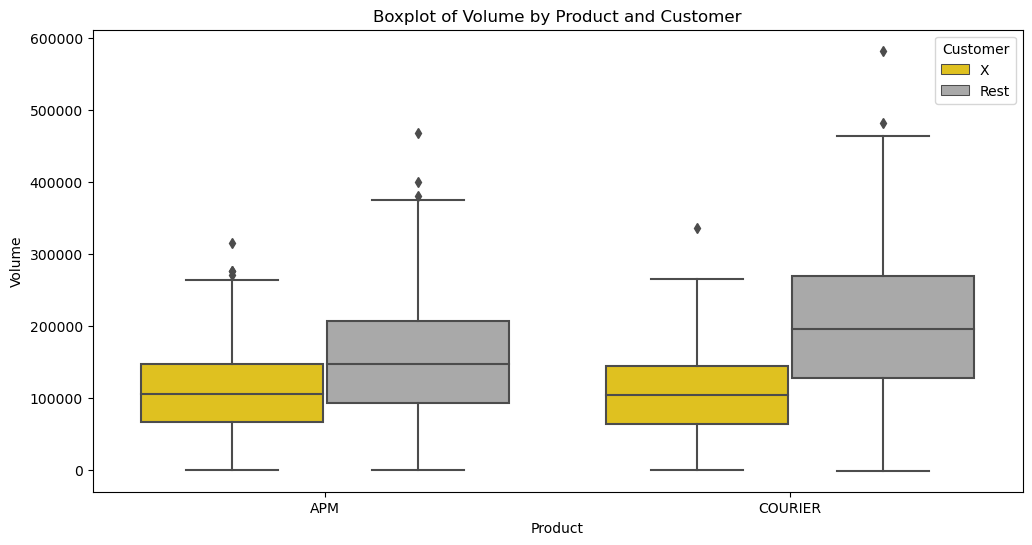

C:\Users\sonia\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


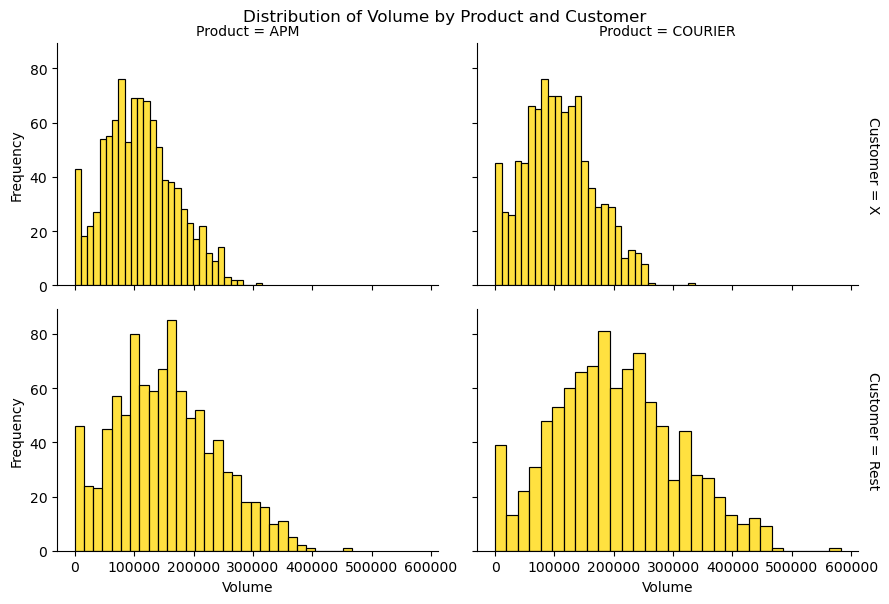

In [19]:
# Boxplot for Volume values depending on product and customer
plt.figure(figsize=(12, 6))
sns.boxplot(x='Product', y='Volume', hue='Customer', data=posting_volume_df, palette=['gold', 'darkgray'])
plt.title('Boxplot of Volume by Product and Customer')
plt.ylabel('Volume')
plt.xlabel('Product')
plt.legend(title='Customer')
plt.show()

gold_color = "#FFD700"

# Histogram for Volume values depending on the product and customer
g = sns.FacetGrid(posting_volume_df, col="Product", row="Customer", margin_titles=True, height=3, aspect=1.5, )
g.map(sns.histplot, "Volume", bins=30, color=gold_color)
g.set_axis_labels("Volume", "Frequency")
g.fig.suptitle('Distribution of Volume by Product and Customer', y=1.0)
plt.show()

#### Analyzing the charts:
##### Volume by product and customer:
* Rest volumes are more diverse and have larger outliers in both products.
* Rest shows larger median volumes than customer X for both products.
##### Histograms of volume distribution by product and customer:
* For product APM, customer X shows a distribution with a concentration around the median, and Rest shows a few outliers.
* For product COURIER, both customer X and Rest show a similar distribution, but Rest has a larger range of volumes.
* In both products, customer X shows a larger number of smaller volumes.

#### Conclusions
The differences in data between customer X and Rest are explained by the fact that X is an isolated customer, and Rest is the rest of the customers. For this reason, volumes reach larger and more variable values ​​for Rest.

In [20]:
missing_values_statistic(posting_volume_df)

Missing values count  Percentage of missing data
postingDateFk                     0                         0.0
Product                           0                         0.0
Customer                          0                         0.0
Volume                            0                         0.0

#### Missing values:
None.

### Changes to implement:
* Fixed the issue of negative data in **Volume**.
* Replaced the **PostingDateFk** column with a date type.

### 1.3. Clients_Orders <a name="wstępna_analiza_3"></a>

In [21]:
head_and_tail(clients_orders_df)

First and last rows of the data frame:


DateId         Orders
0  20230101  161366.064671
1  20230102  296627.324653
2  20230103  378262.368584
3  20230104  320907.583398

DateId         Orders
239  20230828  334471.057583
240  20230829  407334.926198
241  20230830  354357.441720
242  20230831            NaN

In [22]:
shape(clients_orders_df)

Number of rows and columns:
(243, 2)


In [23]:
info(clients_orders_df)

Info about the data frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DateId  243 non-null    int64  
 1   Orders  242 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 3.9 KB


None

In [24]:
statistics(clients_orders_df)

Descriptive statistic of the data frame:


DateId         Orders
count  2.430000e+02     242.000000
mean   2.023047e+07  275094.376827
std    2.303691e+02   70057.800956
min    2.023010e+07   72473.494555
25%    2.023030e+07  224505.534006
50%    2.023050e+07  273695.994969
75%    2.023070e+07  325644.229278
max    2.023083e+07  416068.107760

#### Column description:

1. **DateId**: Date in YYYYMMDD format (can be used as Foreign key).

2. **Orders**: Number of orders.

#### Analysis and conclusions:
* The average value of daily orders is about 275094.
* The standard deviation is about 70058, which indicates quite a large variability in the number of daily orders.
* The minimum number of orders is about 72473, and the maximum is about 416068. These values ​​suggest a large variability in the number of daily orders.

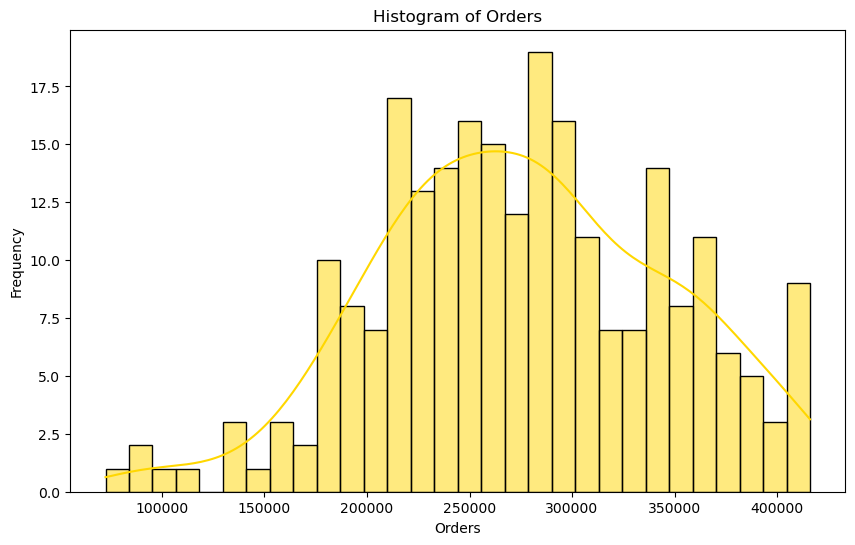

In [25]:
# Histogram for Orders
plt.figure(figsize=(10, 6))
sns.histplot(clients_orders_df['Orders'].dropna(), bins=30, kde=True, color=gold_color)
plt.title('Histogram of Orders')
plt.xlabel('Orders')
plt.ylabel('Frequency')
plt.show()

#### Histogram Analysis:
* The order distribution is close to normal, but skewed slightly to the right.
* The largest number of orders is concentrated around the values 200,000 to 300,000.
* There are outliers at the beginning and end of the order range, with orders below 150,000 and above 400,000.

In [26]:
missing_values_statistic(clients_orders_df)

Missing values count  Percentage of missing data
DateId                     0                    0.000000
Orders                     1                    0.411523

#### Missing values:
The **Orders** column has one missing value, which is 0.41% of the total data in the column.

### Changes to implement:
* Fixed missing value in **Orders**.
* Replaced **DateId** column with date type.

### 1.4. Temperature <a name="wstępna_analiza_4"></a>

In [27]:
head_and_tail(temperature_df)

First and last rows of the data frame:


Nazwa stacji   Rok  Miesiac  Dzien  Maksymalna temperatura dobowa  \
0       KRAKOW  2021        1      1                            0.5   
1       KRAKOW  2021        1      2                            4.4   
2       KRAKOW  2021        1      3                            4.0   
3       KRAKOW  2021        1      4                            4.9   

   Minimalna temperatura dobowa  Srednia temperatura dobowa  \
0                          -1.2                        -0.5   
1                          -1.6                         0.8   
2                          -0.9                         1.1   
3                          -0.7                         1.7   

   Suma dobowa opadow [mm]  Pokrywa sniegu [cm]  
0                      0.0                    0  
1                      0.0                    0  
2                      0.0                    0  
3                      7.1                    0

Nazwa stacji   Rok  Miesiac  Dzien  Maksymalna temperatura dobowa  \
1942     WARSZAWA  2022       12     28                            4.9   
1943     WARSZAWA  2022       12     29                            8.3   
1944     WARSZAWA  2022       12     30                            8.7   
1945     WARSZAWA  2022       12     31                           13.6   

      Minimalna temperatura dobowa  Srednia temperatura dobowa  \
1942                          -0.2                         2.5   
1943                           3.3                         5.8   
1944                           4.0                         5.9   
1945                           0.6                         8.3   

      Suma dobowa opadow [mm]  Pokrywa sniegu [cm]  
1942                      0.0                    0  
1943                      0.0                    0  
1944                      0.0                    0  
1945                      0.0                    0

In [28]:
shape(temperature_df)

Number of rows and columns:
(1946, 9)


In [29]:
info(temperature_df)

Info about the data frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1946 entries, 0 to 1945
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Nazwa stacji                   1946 non-null   object 
 1   Rok                            1946 non-null   int64  
 2   Miesiac                        1946 non-null   int64  
 3   Dzien                          1946 non-null   int64  
 4   Maksymalna temperatura dobowa  1946 non-null   float64
 5   Minimalna temperatura dobowa   1946 non-null   float64
 6   Srednia temperatura dobowa     1946 non-null   float64
 7   Suma dobowa opadow [mm]        1946 non-null   float64
 8   Pokrywa sniegu [cm]            1946 non-null   int64  
dtypes: float64(4), int64(4), object(1)
memory usage: 137.0+ KB


None

In [30]:
unique_values = temperature_df['Nazwa stacji'].unique()
print(f"Unique values in column Nazwa stacji:")
print(unique_values)

Unique values in column Nazwa stacji:
['KRAKOW' 'WARSZAWA']


Brak błędnych danych typu object.

In [31]:
statistics(temperature_df)

Descriptive statistic of the data frame:


Rok      Miesiac        Dzien  Maksymalna temperatura dobowa  \
count  1946.000000  1946.000000  1946.000000                    1946.000000   
mean   2021.874615     6.026721    15.716341                      14.826310   
std       0.780681     3.315044     8.797155                       9.660984   
min    2021.000000     1.000000     1.000000                     -12.800000   
25%    2021.000000     3.000000     8.000000                       6.700000   
50%    2022.000000     6.000000    16.000000                      15.400000   
75%    2022.000000     9.000000    23.000000                      22.800000   
max    2023.000000    12.000000    31.000000                      36.700000   

       Minimalna temperatura dobowa  Srednia temperatura dobowa  \
count                   1946.000000                 1946.000000   
mean                       6.286948                   10.062384   
std                        7.420518                    8.285873   
min                      -17.500000                  -15.700000   
25%                        0.400000                    3.100000   
50%                        6.100000                   10.000000   
75%                       12.500000                   17.200000   
max                       21.900000                   28.200000   

       Suma dobowa opadow [mm]  Pokrywa sniegu [cm]  
count              1946.000000          1946.000000  
mean                  1.078263             0.345838  
std                   4.161008             2.033935  
min                   0.000000             0.000000  
25%                   0.000000             0.000000  
50%                   0.000000             0.000000  
75%                   0.000000             0.000000  
max                 103.400000            27.000000

#### Column description:
1. **Nazwa stacji**: Name of the measurement station (e.g., KRAKOW, WARSZAWA)
2. **Rok**: Year of measurement
3. **Miesiac**: Month of measurement
4. **Dzien**: Day of measurement
5. **Maksymalna temperatura dobowa**: Maximum daily temperature recorded (°C)
6. **Minimalna temperatura dobowa**:  Minimum daily temperature recorded (°C)
7. **Srednia temperatura dobowa**: Average daily temperature recorded (°C)
8. **Suma dobowa opadow [mm]**: Total daily precipitation (mm)
9. **Pokrywa sniegu [cm]**: Snow cover (cm)

In [32]:
missing_values_statistic(temperature_df)

Missing values count  \
Nazwa stacji                                      0   
Rok                                               0   
Miesiac                                           0   
Dzien                                             0   
Maksymalna temperatura dobowa                     0   
Minimalna temperatura dobowa                      0   
Srednia temperatura dobowa                        0   
Suma dobowa opadow [mm]                           0   
Pokrywa sniegu [cm]                               0   

                               Percentage of missing data  
Nazwa stacji                                          0.0  
Rok                                                   0.0  
Miesiac                                               0.0  
Dzien                                                 0.0  
Maksymalna temperatura dobowa                         0.0  
Minimalna temperatura dobowa                          0.0  
Srednia temperatura dobowa                            0.0  
Suma dobowa opadow [mm]                               0.0  
Pokrywa sniegu [cm]                                   0.0

#### Missing values:
None.

### Changes to implement:
* Created a **date** (date type) column (from Year, Month, Day columns) to allow Temperature to be connected to other databases.
* Created a new dataset with values ​​that are averages of data from both cities (Warsaw and Krakow) for the same day.

## 2.  Data processing <a name="przetwarzanie_danych"></a>

### 2.1. DimDates <a name="przetwarzanie_danych_1"></a>

#### Missing data

In [33]:
value_counts = dim_dates_df['isWeekendParcelServiceBreakInd'].value_counts()
count_of_ones = value_counts.get(1)
rows = dim_dates_df.shape[0]
percantage_of_ones = round((count_of_ones / rows), 2)
print(f"Count of ones: {count_of_ones}")
print(f"Percantage of ones: {percantage_of_ones}%")

Count of ones: 22
Percantage of ones: 0.02%


The **isWeekendParcelServiceBreakInd** column contains the weekend courier service break indicator (0/1). As the statistics show, the number of 1 values in this column is very small. This means that the value 0 is the dominant category. In this situation, when about 25% of the data in this column is missing, using the dominant value (0) to fill in the missing data seems to be the right strategy.<br>
Since the number of days with courier service breaks (1) is very small, their impact on the overall results of the prediction model will also be small, given the large amount of other data in the DimDates table. Filling in the missing values as 0 should not affect the overall predictions.

In [34]:
most_frequent_value = dim_dates_df['isWeekendParcelServiceBreakInd'].mode()[0]
dim_dates_df['isWeekendParcelServiceBreakInd'].fillna(most_frequent_value, inplace=True)

missing_values_after = dim_dates_df['isWeekendParcelServiceBreakInd'].isnull().sum()
print("\nMissing values after filling:")
print(missing_values_after)


Missing values after filling:
0


#### Converting datePk column to date type

In [35]:
dim_dates_df['datePk'] = pd.to_datetime(dim_dates_df['datePk'], format='%Y%m%d')

In [36]:
print("\nData type of datePk after conversion:")
print(dim_dates_df['datePk'].dtype)


Data type of datePk after conversion:
datetime64[ns]


In [37]:
dim_dates_df=dim_dates_df.rename(columns={"datePk": "date"})

### 2.2. PostingVolume <a name="przetwarzanie_danych_2"></a>

#### Negative values in Volume

In [38]:
print(posting_volume_df[posting_volume_df['Volume'] < 0])
negative_volume_count = posting_volume_df[posting_volume_df['Volume'] < 0].shape[0]
rows = posting_volume_df.shape[0]
percantage_of_negative_volume = round((negative_volume_count/rows), 3)
print(f"Percantage of negative values: {percantage_of_negative_volume}%")

     postingDateFk  Product Customer      Volume
17        20210118      APM        X -501.072484
990       20210118      APM     Rest -565.057691
1963      20210118  COURIER        X -421.967589
2936      20210118  COURIER     Rest -876.759667
Percantage of negative values: 0.001%


Negative values in the **Volume** column are unexpected and indicate errors in the data, because the volume of shipments should be a positive value. All these values have the same shipment date, which may indicate an error when entering the data. Due to the very small amount of such data, they can be replaced with 0.

In [39]:
posting_volume_df['Volume'] = posting_volume_df['Volume'].apply(lambda x: max(x, 0))

In [40]:
negative_values_count = posting_volume_df[posting_volume_df['Volume'] < 0].shape[0]
print(f"Negative values count: {negative_values_count}")

Negative values count: 0


#### Converting PostingDateFk column to date type

In [41]:
posting_volume_df['postingDateFk'] = pd.to_datetime(posting_volume_df['postingDateFk'], format='%Y%m%d')

In [42]:
print("\nData type of postingDateFk after conversion:")
print(posting_volume_df['postingDateFk'].dtypes)


Data type of postingDateFk after conversion:
datetime64[ns]


In [43]:
posting_volume_df=posting_volume_df.rename(columns={"postingDateFk": "date"})

#### Creating a **daily_volume_df** table containing the summed **Volume** of all customers and products for a given day.

In [44]:
daily_volume_df = posting_volume_df.groupby('date')['Volume'].sum().reset_index()

daily_volume_df.head()
shape(daily_volume_df)

Number of rows and columns:
(973, 2)


### 2.3. Clients_Orders <a name="przetwarzanie_danych_3"></a>

#### Missing data in Orders

There is one missing value in the Orders column. This can be resolved by replacing it with the median of the data in the column.

In [45]:
clients_orders_df['Orders'].fillna(clients_orders_df['Orders'].mean(), inplace=True)

In [46]:
missing_values_statistic(clients_orders_df)

Missing values count  Percentage of missing data
DateId                     0                         0.0
Orders                     0                         0.0

#### Converting PostingDateFk column to date type

In [47]:
clients_orders_df['DateId'] = pd.to_datetime(clients_orders_df['DateId'], format='%Y%m%d')

In [48]:
print("\nData type of DateId after conversion:")
print(clients_orders_df['DateId'].dtypes)


Data type of DateId after conversion:
datetime64[ns]


In [49]:
clients_orders_df=clients_orders_df.rename(columns={"DateId": "date"})

### 2.4. Temperature <a name="przetwarzanie_danych_4"></a>

#### Creating a Date column of date type from the Year, Month and Day columns

In [50]:
temperature_df.rename(columns={'Rok': 'year', 'Miesiac': 'month', 'Dzien': 'day'}, inplace=True)
temperature_df['date'] = pd.to_datetime(temperature_df[['year', 'month', 'day']])

In [51]:
temperature_df.drop(columns=['year', 'month', 'day'], inplace=True)

In [52]:
temperature_df.head(3)

Nazwa stacji  Maksymalna temperatura dobowa  Minimalna temperatura dobowa  \
0       KRAKOW                            0.5                          -1.2   
1       KRAKOW                            4.4                          -1.6   
2       KRAKOW                            4.0                          -0.9   

   Srednia temperatura dobowa  Suma dobowa opadow [mm]  Pokrywa sniegu [cm]  \
0                        -0.5                      0.0                    0   
1                         0.8                      0.0                    0   
2                         1.1                      0.0                    0   

        date  
0 2021-01-01  
1 2021-01-02  
2 2021-01-03

#### Creating a table with average weather values

In [53]:
temperature_avg_df = temperature_df.groupby('date').agg({
    'Maksymalna temperatura dobowa': 'mean',
    'Minimalna temperatura dobowa': 'mean',
    'Srednia temperatura dobowa': 'mean',
    'Suma dobowa opadow [mm]': 'mean',
    'Pokrywa sniegu [cm]': 'mean'
}).reset_index()

In [54]:
temperature_avg_df.columns = ['date', 'AvgMaxTemp', 'AvgMinTemp', 'AvgMeanTemp', 'AvgPrecipitation', 'AvgSnowCover']

In [55]:
shape(temperature_avg_df)

Number of rows and columns:
(973, 6)


In [56]:
head_and_tail(temperature_avg_df)

First and last rows of the data frame:


date  AvgMaxTemp  AvgMinTemp  AvgMeanTemp  AvgPrecipitation  \
0 2021-01-01        0.70       -1.20        -0.35              0.00   
1 2021-01-02        2.80       -1.25         0.55              0.00   
2 2021-01-03        3.20       -0.05         1.15              0.00   
3 2021-01-04        4.15       -0.10         1.95              3.55   

   AvgSnowCover  
0           0.0  
1           0.0  
2           0.0  
3           0.0

date  AvgMaxTemp  AvgMinTemp  AvgMeanTemp  AvgPrecipitation  \
969 2023-08-28       23.25       17.55        19.45              0.05   
970 2023-08-29       25.55       17.85        21.05              0.45   
971 2023-08-30       21.80       16.70        18.30              0.15   
972 2023-08-31       22.45       14.80        17.05              0.05   

     AvgSnowCover  
969           0.0  
970           0.0  
971           0.0  
972           0.0

## 3.  Data joining <a name="laczenie_danych"></a>

### Table containing combined data from 4 databases

In [57]:
combined_df = daily_volume_df.merge(dim_dates_df, on='date', how='left') \
                         .merge(temperature_avg_df, on='date', how='left') \
                         .merge(clients_orders_df, on='date', how='left')

In [58]:
head_and_tail(combined_df)

First and last rows of the data frame:


date         Volume      dateId  dateYear  dateYearISO  dateMonthYear  \
0 2021-01-01   11367.648290  2021-01-01      2021         2020         1.2021   
1 2021-01-02  106467.612644  2021-01-02      2021         2020         1.2021   
2 2021-01-03  298554.245374  2021-01-03      2021         2020         1.2021   
3 2021-01-04  167551.554724  2021-01-04      2021         2021         1.2021   

  dateWeekYearISO dateQuarterYear  dateMonth  dateDay dateDaySuffix  \
0        T53-2020         Q1-2021          1        1            st   
1        T53-2020         Q1-2021          1        2            nd   
2        T53-2020         Q1-2021          1        3            rd   
3         T1-2021         Q1-2021          1        4            th   

   dateWeekDay dateWeekDayName dateWeekDayNameShort  \
0            6          Friday                  FRI   
1            7        Saturday                  SAT   
2            1          Sunday                  SUN   
3            2          Monday                  MON   

  dateWeekDayNameFirstLetter  dateDayOfYear  dateWeekOfMonth  dateWeekOfYear  \
0                          F              1                1               1   
1                          S              2                1               1   
2                          S              3                2               2   
3                          M              4                2               2   

   dateWeekOfYearISO dateMonthName dateMonthNameShort  \
0                 53       January                JAN   
1                 53       January                JAN   
2                 53       January                JAN   
3                  1       January                JAN   

  dateMonthNameFirstLetter  dateQuarter dateQuarterName dateQuarterShort  \
0                        J            1           First            Qtr 1   
1                        J            1           First            Qtr 1   
2                        J            1           First            Qtr 1   
3                        J            1           First            Qtr 1   

   dateIsWeekend  dateIsHolidayInd  dateWeekDayStartsMonday dateWeekDayNamePL  \
0              0                 1                        5            Piątek   
1              1                 0                        6            Sobota   
2              1                 0                        7         Niedziela   
3              0                 0                        1      Poniedziałek   

  dateMonthNamePL  dateWeekOfYearStartsMonday  firstDayWorkBefore  \
0         Styczeń                           1            20201230   
1         Styczeń                           1            20201230   
2         Styczeń                           1            20201230   
3         Styczeń                           2            20201230   

   firstDayWorkAfter  firstDayNoHolidayNoSaturdayAfter  \
0           20210104                          20210103   
1           20210104                          20210103   
2           20210104                          20210104   
3           20210105                          20210105   

   firstDayNoHolidayNoSundayAfter  firstDayNoHolidayNoSaturdayAfterData  \
0                        20210102                              20210103   
1                        20210104                              20210103   
2                        20210104                              20210104   
3                        20210105                              20210105   

  firstDayNoSaturdayNoHolidayOrSundayHolidayName  \
0                                            SUN   
1                                            SUN   
2                                            MON   
3                                            TUE   

   firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday  \
0                                                    0   
1                                                    0   
2                                               

date         Volume      dateId  dateYear  dateYearISO  \
969 2023-08-28  624376.598443  2023-08-28      2023         2023   
970 2023-08-29  916679.147861  2023-08-29      2023         2023   
971 2023-08-30  927152.139888  2023-08-30      2023         2023   
972 2023-08-31  730302.951767  2023-08-31      2023         2023   

     dateMonthYear dateWeekYearISO dateQuarterYear  dateMonth  dateDay  \
969         8.2023        T35-2023         Q3-2023          8       28   
970         8.2023        T35-2023         Q3-2023          8       29   
971         8.2023        T35-2023         Q3-2023          8       30   
972         8.2023        T35-2023         Q3-2023          8       31   

    dateDaySuffix  dateWeekDay dateWeekDayName dateWeekDayNameShort  \
969            th            2          Monday                  MON   
970            th            3         Tuesday                  TUE   
971            th            4       Wednesday                  WED   
972            st            5        Thursday                  THU   

    dateWeekDayNameFirstLetter  dateDayOfYear  dateWeekOfMonth  \
969                          M            240                5   
970                          T            241                5   
971                          W            242                5   
972                          T            243                5   

     dateWeekOfYear  dateWeekOfYearISO dateMonthName dateMonthNameShort  \
969              35                 35        August                AUG   
970              35                 35        August                AUG   
971              35                 35        August                AUG   
972              35                 35        August                AUG   

    dateMonthNameFirstLetter  dateQuarter dateQuarterName dateQuarterShort  \
969                        A            3           Third            Qtr 3   
970                        A            3           Third            Qtr 3   
971                        A            3           Third            Qtr 3   
972                        A            3           Third            Qtr 3   

     dateIsWeekend  dateIsHolidayInd  dateWeekDayStartsMonday  \
969              0                 0                        1   
970              0                 0                        2   
971              0                 0                        3   
972              0                 0                        4   

    dateWeekDayNamePL dateMonthNamePL  dateWeekOfYearStartsMonday  \
969      Poniedziałek        Sierpień                          36   
970            Wtorek        Sierpień                          36   
971             Środa        Sierpień                          36   
972          Czwartek        Sierpień                          36   

     firstDayWorkBefore  firstDayWorkAfter  firstDayNoHolidayNoSaturdayAfter  \
969            20230825           20230829                          20230829   
970            20230828           20230830                          20230830   
971            20230829           20230831                          20230831   
972            20230830           20230901                          20230901   

     firstDayNoHolidayNoSundayAfter  firstDayNoHolidayNoSaturdayAfterData  \
969                        20230829                              20230829   
970                        20230830                              20230830   
971                        20230831                              20230831   
972                        20230901                              20230901   

    firstDayNoSaturdayNoHolidayOrSundayHolidayName  \
969                                            TUE   
970                                            WED   
971                                            THU   
972                                            FRI   

     firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday  \
969                                                   

In [59]:
shape(combined_df)

Number of rows and columns:
(973, 60)


In [60]:
missing_values_statistic(combined_df)

Missing values count  \
date                                                                    0   
Volume                                                                  0   
dateId                                                                  0   
dateYear                                                                0   
dateYearISO                                                             0   
dateMonthYear                                                           0   
dateWeekYearISO                                                         0   
dateQuarterYear                                                         0   
dateMonth                                                               0   
dateDay                                                                 0   
dateDaySuffix                                                           0   
dateWeekDay                                                             0   
dateWeekDayName                                                         0   
dateWeekDayNameShort                                                    0   
dateWeekDayNameFirstLetter                                              0   
dateDayOfYear                                                           0   
dateWeekOfMonth                                                         0   
dateWeekOfYear                                                          0   
dateWeekOfYearISO                                                       0   
dateMonthName                                                           0   
dateMonthNameShort                                                      0   
dateMonthNameFirstLetter                                                0   
dateQuarter                                                             0   
dateQuarterName                                                         0   
dateQuarterShort                                                        0   
dateIsWeekend                                                           0   
dateIsHolidayInd                                                        0   
dateWeekDayStartsMonday                                                 0   
dateWeekDayNamePL                                                       0   
dateMonthNamePL                                                         0   
dateWeekOfYearStartsMonday                                              0   
firstDayWorkBefore                                                      0   
firstDayWorkAfter                                                       0   
firstDayNoHolidayNoSaturdayAfter                                        0   
firstDayNoHolidayNoSundayAfter                                          0   
firstDayNoHolidayNoSaturdayAfterData                                    0   
firstDayNoSaturdayNoHolidayOrSundayHolidayName                          0   
firstDayNoSaturdayNoHolidayOrSundayHolidayIsHoliday                     0   
firstDayNoSaturdayNoHolidayOrSundayHoliday                              0   
isThuHolyday                                                            0   
isFriHolyday                                                            0   
isSatHolyday                                                            0   
isWeekendParcelServiceBreakInd                                          0   
courierBillingPeriodDateFk                                              0   
courierBillingPeriodStartDateFk                                         0   
courierBillingPeriodEndDateFk                                           0   
xlsDate                                                                 0   
dwhDateFrom                                                             0   
dwhDateTo                                                               0   
dwhCurrRec                                                              0   
dwhAuditCd                                                              0   
dwhAuditCp                                       

#### Missing data:
In the combined table, only the **Orders** column has missing data, which is because this data was only provided from the beginning of 2023. This column contains important information that is forecasted by customer X, but its usefulness in predictive modeling is limited by the large number of missing values. The lack of historical data limits the model's ability to predict based on long-term trends.

### Creating additional tables divided by customers: X or Rest

In [61]:
client_x_summed_df = posting_volume_df[posting_volume_df['Customer'] == 'X'].groupby('date')['Volume'].sum().reset_index()
client_rest_summed_df = posting_volume_df[posting_volume_df['Customer'] == 'Rest'].groupby('date')['Volume'].sum().reset_index()

combined_df_x = client_x_summed_df.merge(dim_dates_df, on='date', how='left') \
                                  .merge(temperature_avg_df, on='date', how='left') \
                                  .merge(clients_orders_df, on='date', how='left')

combined_df_rest = client_rest_summed_df.merge(dim_dates_df, on='date', how='left') \
                                        .merge(temperature_avg_df, on='date', how='left') \
                                        .merge(clients_orders_df, on='date', how='left')

## 4. Exploratory Data Analysis <a name="eda"></a>

### 4.1. Trends and Seasonality in Shipments Data <a name="eda_1"></a>

Helper function:

In [62]:
def plot_grouped_bar_chart(combined_df, combined_df_x, combined_df_rest, group_by_col, x_labels, x_label, y_label, title):
    group_analysis = combined_df.groupby(group_by_col)['Volume'].mean().reset_index()
    group_analysis_x = combined_df_x.groupby(group_by_col)['Volume'].mean().reset_index()
    group_analysis_rest = combined_df_rest.groupby(group_by_col)['Volume'].mean().reset_index()

    group_analysis['Customer'] = 'All'
    group_analysis_x['Customer'] = 'X'
    group_analysis_rest['Customer'] = 'Rest'

    group_combined = pd.concat([group_analysis, group_analysis_x, group_analysis_rest])

    plt.figure(figsize=(12, 6))
    sns.barplot(data=group_combined, x=group_by_col, y='Volume', hue='Customer', palette=['gold', 'black', 'darkgray'])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.xticks(ticks=np.arange(len(x_labels)), labels=x_labels)
    plt.show()

### Months

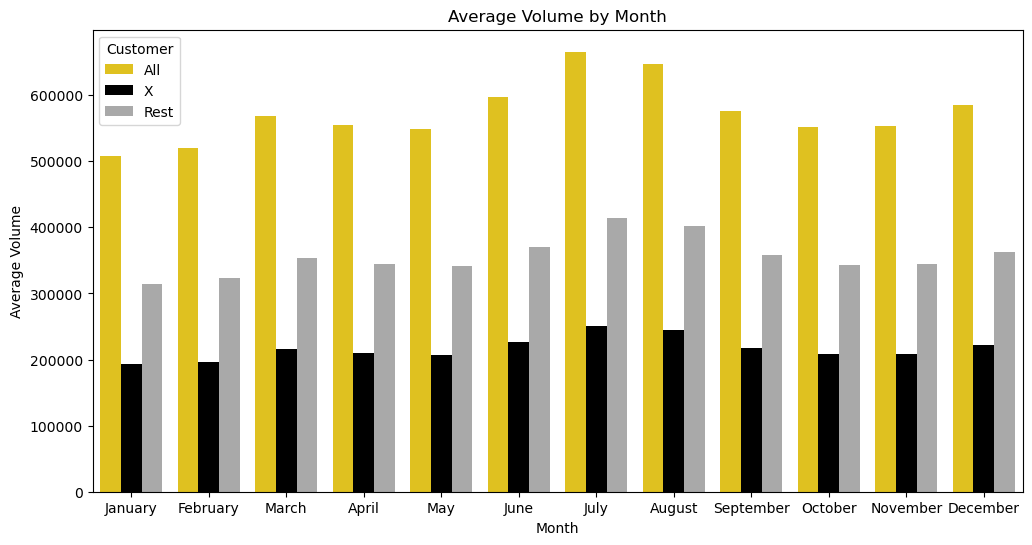

In [63]:
plot_grouped_bar_chart(
    combined_df,
    combined_df_x,
    combined_df_rest,
    group_by_col='dateMonth',
    x_labels=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'],
    x_label='Month',
    y_label='Average Volume',
    title='Average Volume by Month'
)

### Conclusions:
* The number of shipments is clearly higher in the summer months (June, July, August) and in December, which may be related to vacations, back to school or holidays.
* The lowest values of the number of shipments are reached in January. The decrease may be the result of higher results in December.
* Client X: The number of shipments is quite stable throughout the year, fluctuations are smaller compared to the rest.
* The rest: The number of shipments is more variable, lower volumes are particularly visible at the beginning of the year and in the autumn.

### Days of the Week

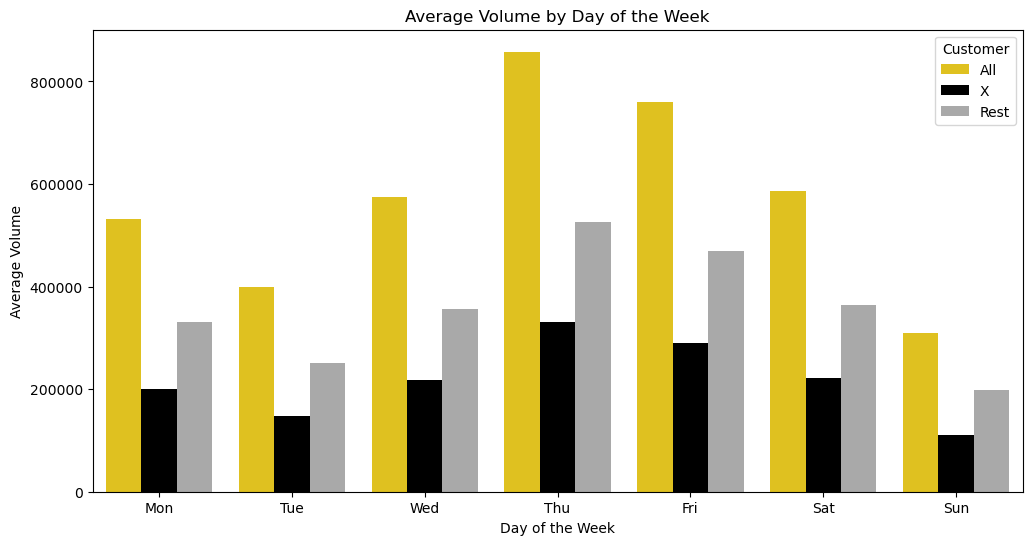

In [64]:
plot_grouped_bar_chart(
    combined_df,
    combined_df_x,
    combined_df_rest,
    group_by_col='dateWeekDay',
    x_labels=['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'],
    x_label='Day of the Week',
    y_label='Average Volume',
    title='Average Volume by Day of the Week'
)

### Conclusions:
* The highest number of shipments is recorded on Thursdays and Fridays, which may suggest an increase in shipment activity towards the end of the work week.

* The lowest number of shipments is recorded on Sundays and Tuesdays.
* Both customer x and the rest notice an increase towards the end of the week.
* Including the days of the week in the forecasting model may be crucial.

### Weekends

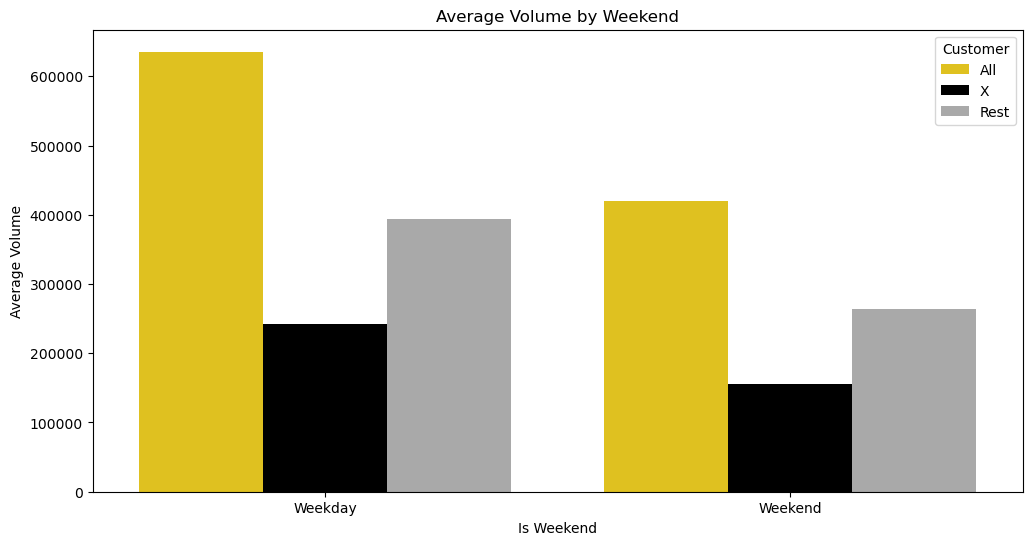

In [65]:
plot_grouped_bar_chart(
    combined_df,
    combined_df_x,
    combined_df_rest,
    group_by_col='dateIsWeekend',
    x_labels=['Weekday', 'Weekend'],
    x_label='Is Weekend',
    y_label='Average Volume',
    title='Average Volume by Weekend'
)

### Conclusions:
* The number of shipments on weekdays is significantly higher than on weekends.
* For client X, there are more shipments on weekdays, similarly to the rest of the clients, which should be included in the forecasting model.

### Holidays

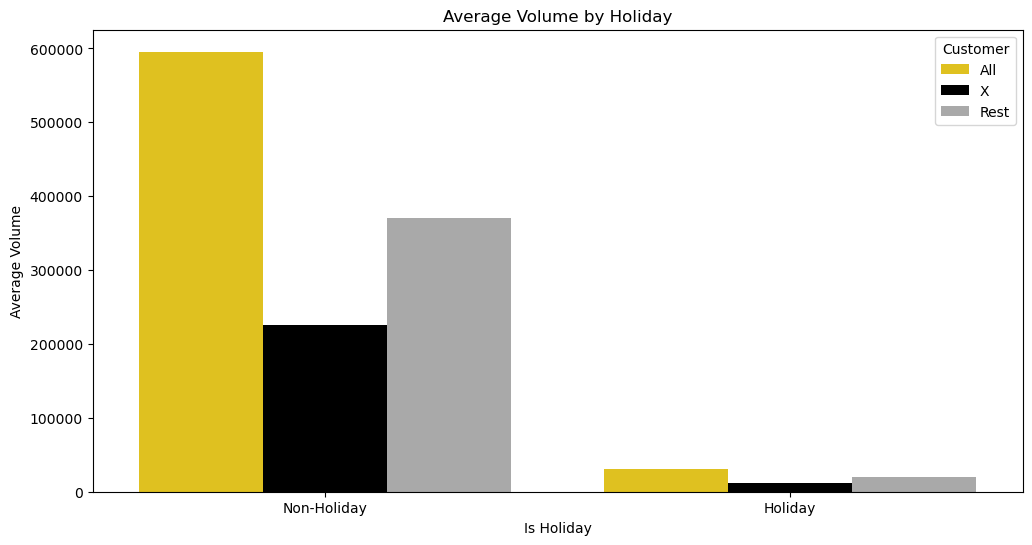

In [66]:
plot_grouped_bar_chart(
    combined_df,
    combined_df_x,
    combined_df_rest,
    group_by_col='dateIsHolidayInd',
    x_labels=['Non-Holiday', 'Holiday'],
    x_label='Is Holiday',
    y_label='Average Volume',
    title='Average Volume by Holiday'
)

### Conclusions:
* The number of shipments on holidays is significantly lower than on non-holidays, which is expected due to lower business activity on these days. It is necessary to include holidays in forecasting the volume of shipments.

### 4.2. Analysis of the impact of customer X's forecasts on actual shipments <a name="eda_2"></a>

C:\Users\sonia\AppData\Local\Temp\ipykernel_18272\14278924.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  combined_df_x_dropna.loc[:, 'Forecast_Error'] = combined_df_x_dropna['Volume'] - combined_df_x_dropna['Orders']


Mean Absolute Error (MAE): 100367.75433039053
Root Mean Squared Error (RMSE): 120469.5230958793


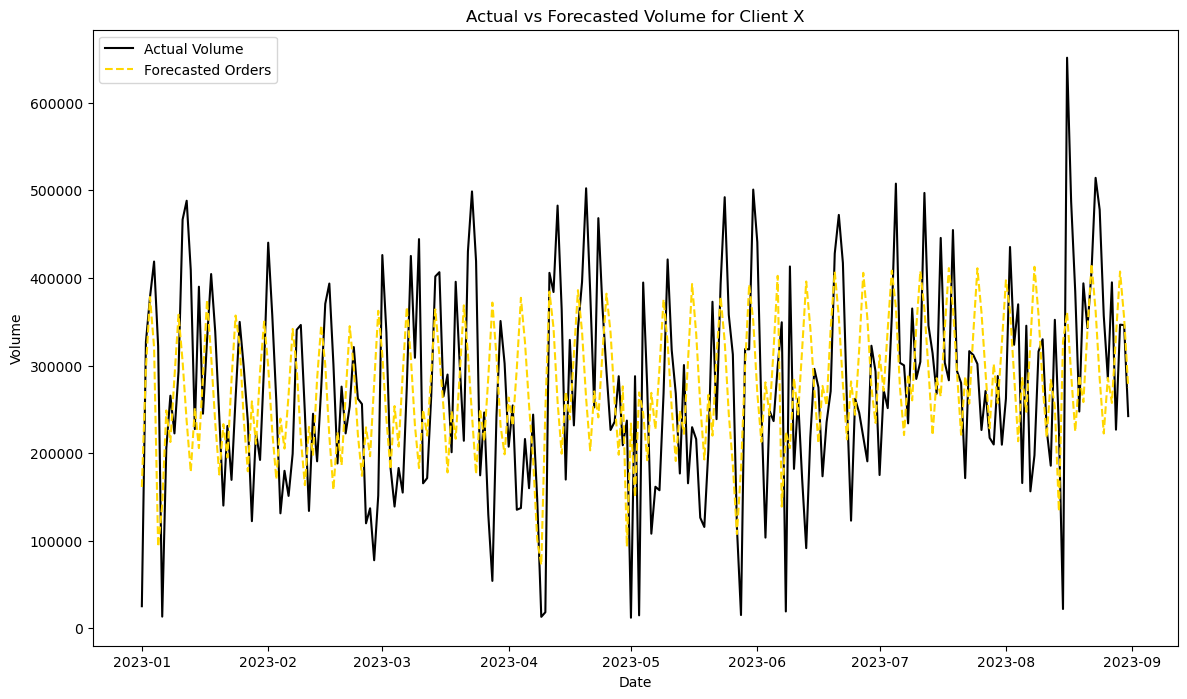

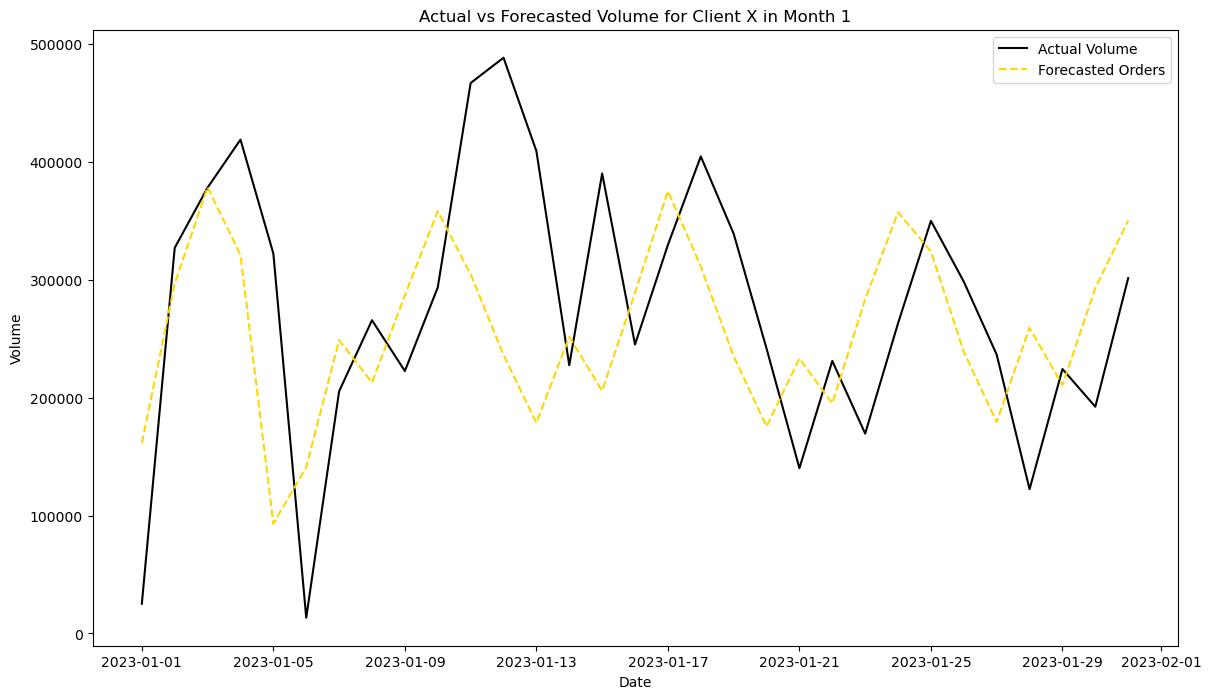

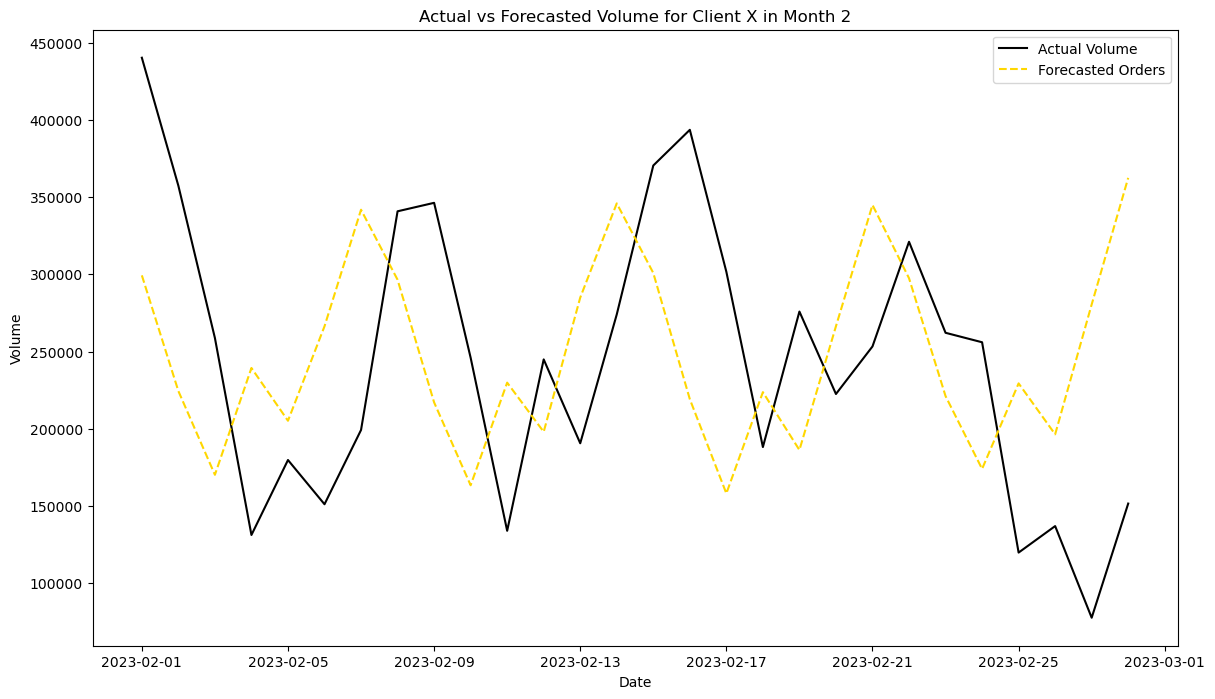

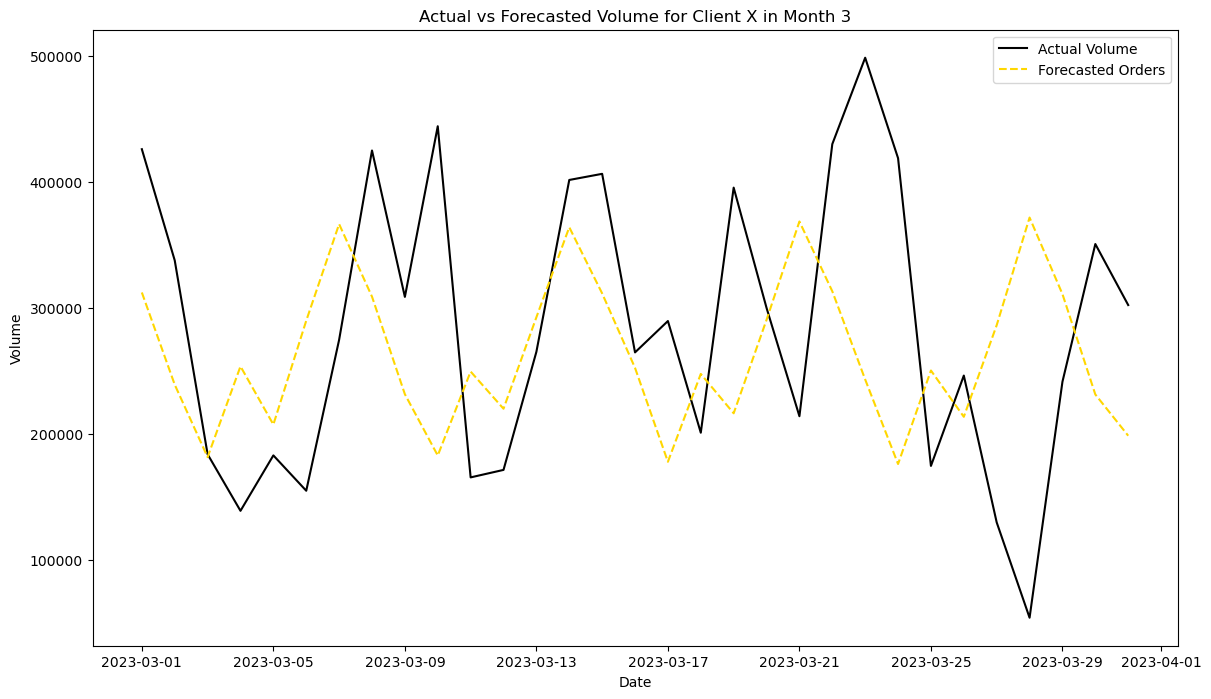

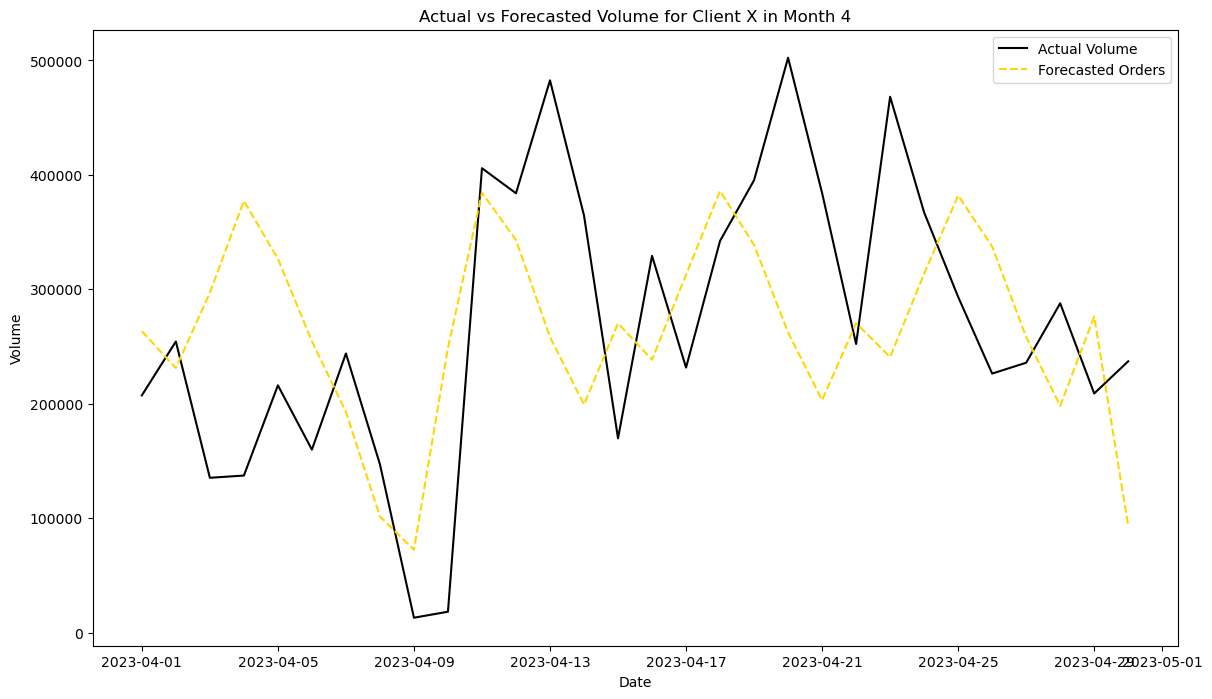

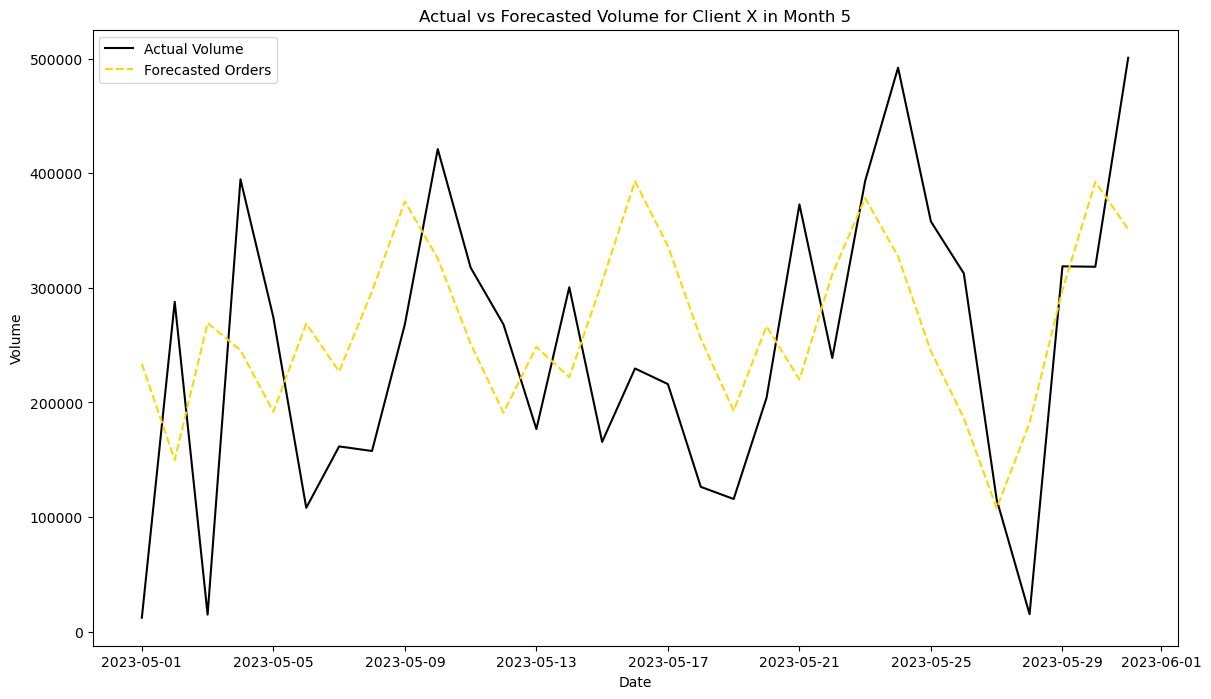

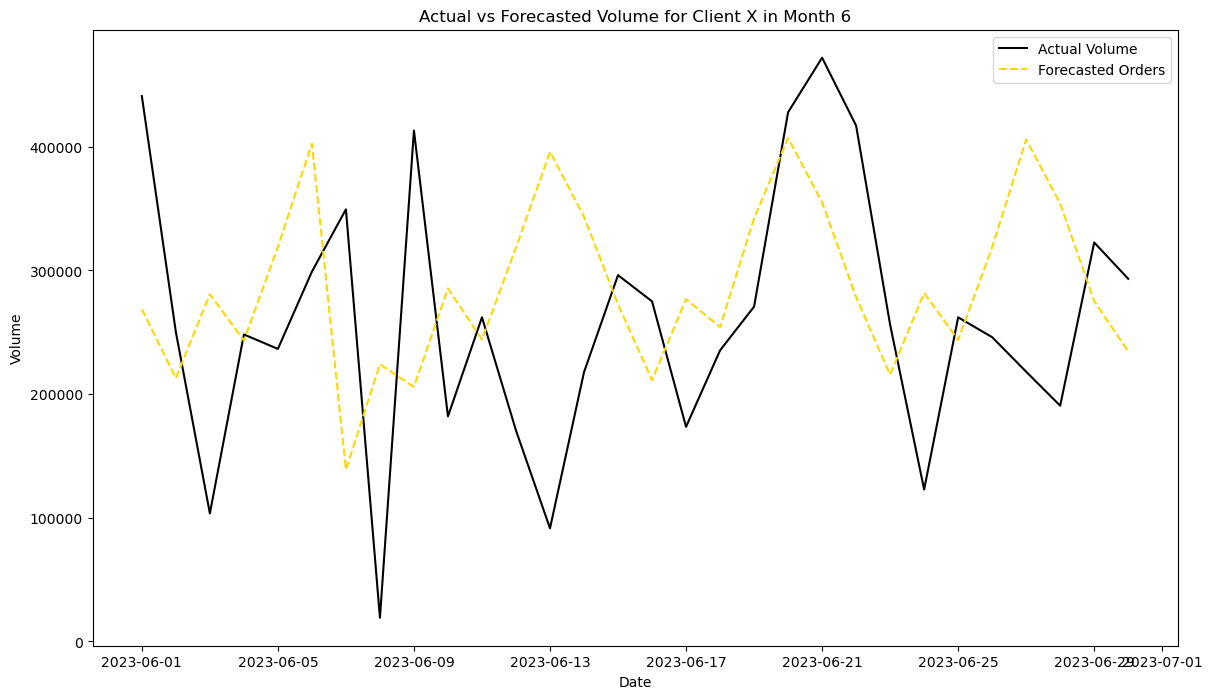

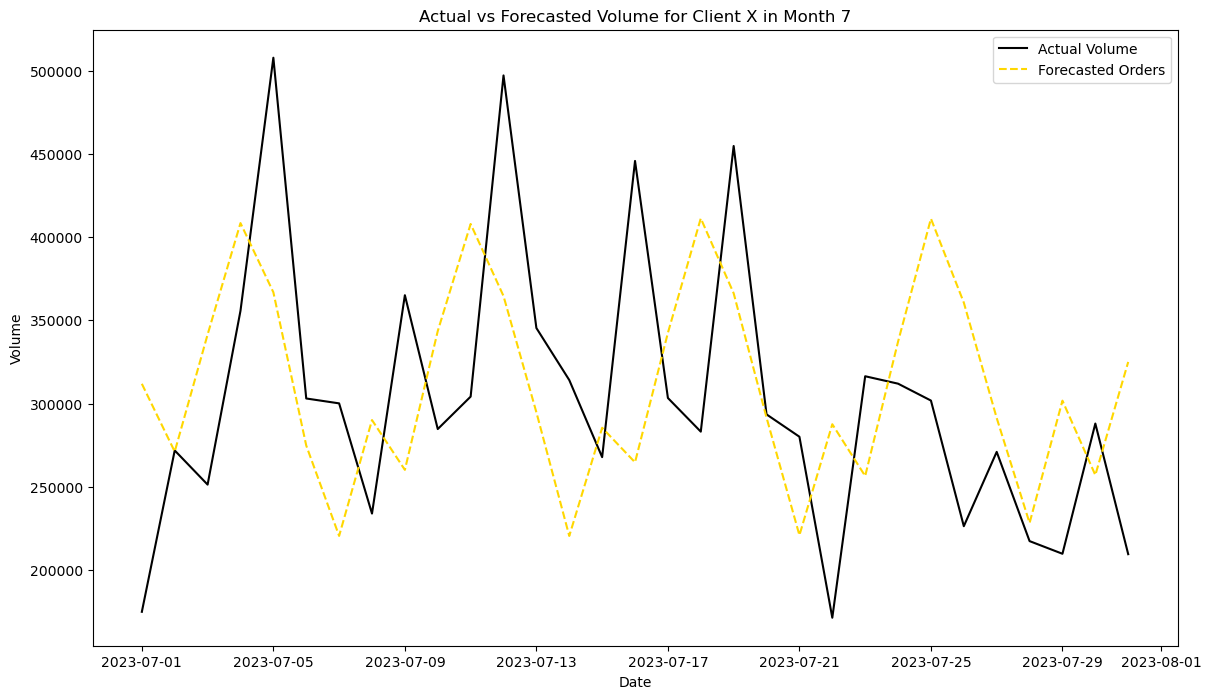

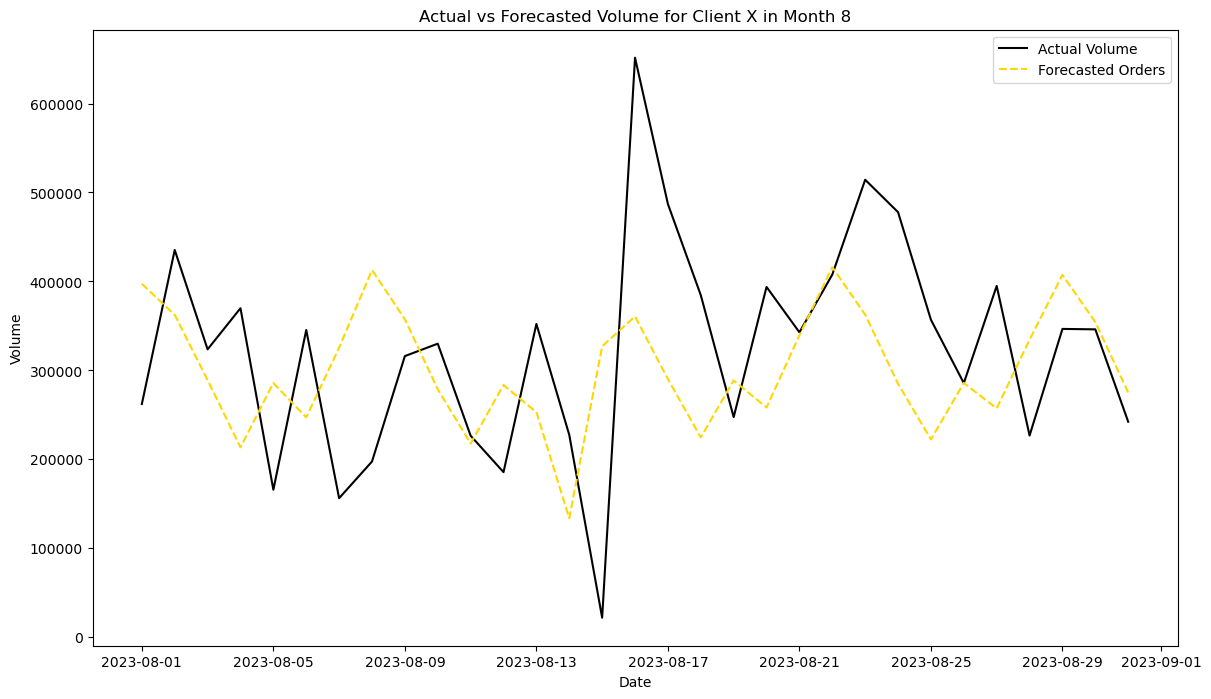

In [67]:
combined_df_x_dropna = combined_df_x.dropna(subset=['Orders'])

combined_df_x_dropna.loc[:, 'Forecast_Error'] = combined_df_x_dropna['Volume'] - combined_df_x_dropna['Orders']

mae = mean_absolute_error(combined_df_x_dropna['Volume'], combined_df_x_dropna['Orders'])
rmse = mean_squared_error(combined_df_x_dropna['Volume'], combined_df_x_dropna['Orders'], squared=False)

print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)

plt.figure(figsize=(14, 8))
plt.plot(combined_df_x_dropna['date'], combined_df_x_dropna['Volume'], label='Actual Volume', color='black')
plt.plot(combined_df_x_dropna['date'], combined_df_x_dropna['Orders'], label='Forecasted Orders', linestyle='--', color='gold')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('Actual vs Forecasted Volume for Client X')
plt.legend()
plt.show()

for month in range(1, 9):
    monthly_data = combined_df_x_dropna[combined_df_x_dropna['dateMonth'] == month]
    plt.figure(figsize=(14, 8))
    plt.plot(monthly_data['date'], monthly_data['Volume'], label='Actual Volume', color='black')
    plt.plot(monthly_data['date'], monthly_data['Orders'], label='Forecasted Orders', linestyle='--', color='gold')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    plt.title(f'Actual vs Forecasted Volume for Client X in Month {month}')
    plt.legend()
    plt.show()


### Observations:
* Throughout the year, there is a large variability in the actual shipment volume.
* Forecasts are usually in line with reality, but there are significant deviations in some periods.
* Clear peaks in actual values ​​in some months (March (23), April (20), June (1, 9), July (5, 12, 15), August (16)) indicate sudden increases that were predicted in the customer's forecast.
* There are also clear decreases that were not predicted (February (28), March (28), May (2), June (8, 13, 24), August (15).
### Conclusion:
Unpredicted peaks and decreases indicate a need for better modeling and consideration of factors that affect sudden changes.


### 4.3. Analysis of the impact of weather conditions on the number of shipments. <a name="eda_3"></a>

Helper function:

In [68]:
def plot_weather_impact(data, data_x, data_rest, x_col, y_col, x_label, y_label, title):
    analysis_all = data.groupby(x_col)[y_col].mean().reset_index()
    analysis_x = data_x.groupby(x_col)[y_col].mean().reset_index()
    analysis_rest = data_rest.groupby(x_col)[y_col].mean().reset_index()

    analysis_all['Customer'] = 'All'
    analysis_x['Customer'] = 'X'
    analysis_rest['Customer'] = 'Rest'

    combined_analysis = pd.concat([analysis_all, analysis_x, analysis_rest])

    plt.figure(figsize=(12, 6))
    sns.scatterplot(data=combined_analysis, x=x_col, y=y_col, hue='Customer', palette=['gold', 'black', 'darkgray'])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()

### Analysis of the impact of average temperature on the number of shipments

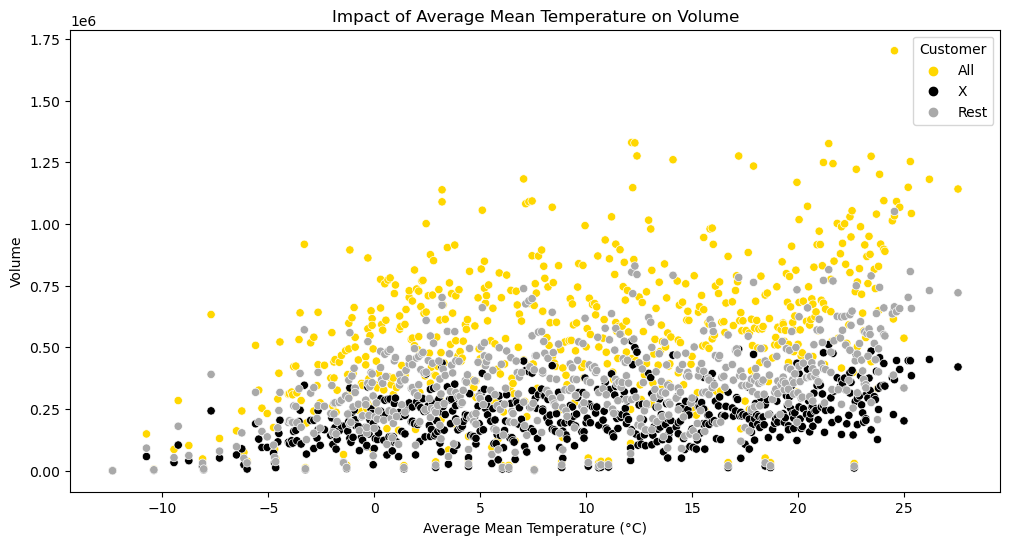

In [69]:
plot_weather_impact(combined_df, combined_df_x, combined_df_rest, 'AvgMeanTemp', 'Volume', 'Average Mean Temperature (°C)', 'Volume', 'Impact of Average Mean Temperature on Volume')

### Analysis and conclusions:
* For all customers, there is a trend of increasing shipments with increasing average temperature.
* The higher the temperature, the greater the number of shipments, which may result from more favorable logistics conditions and increased customer activity in warmer periods.

### Analysis of the impact of rainfall on the number of shipments

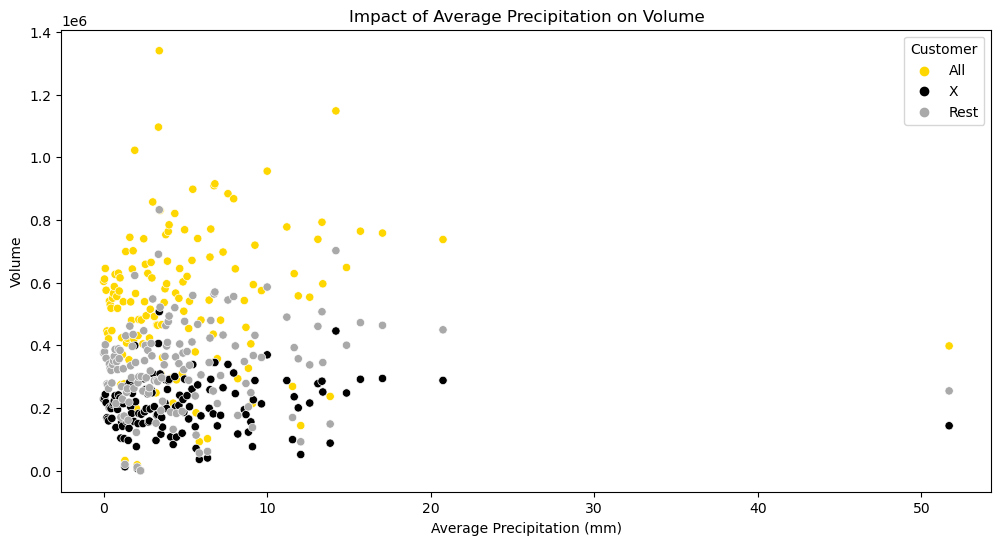

In [70]:
plot_weather_impact(combined_df, combined_df_x, combined_df_rest, 'AvgPrecipitation', 'Volume', 'Average Precipitation (mm)', 'Volume', 'Impact of Average Precipitation on Volume')

### Analysis and conclusions:
* Rain has minimal impact on shipment volume. The highest volumes occur at low rainfall values.
* Rain is not a factor that significantly positively affects logistics and customer activity.

### Analysis of the impact of snow cover on the number of shipments

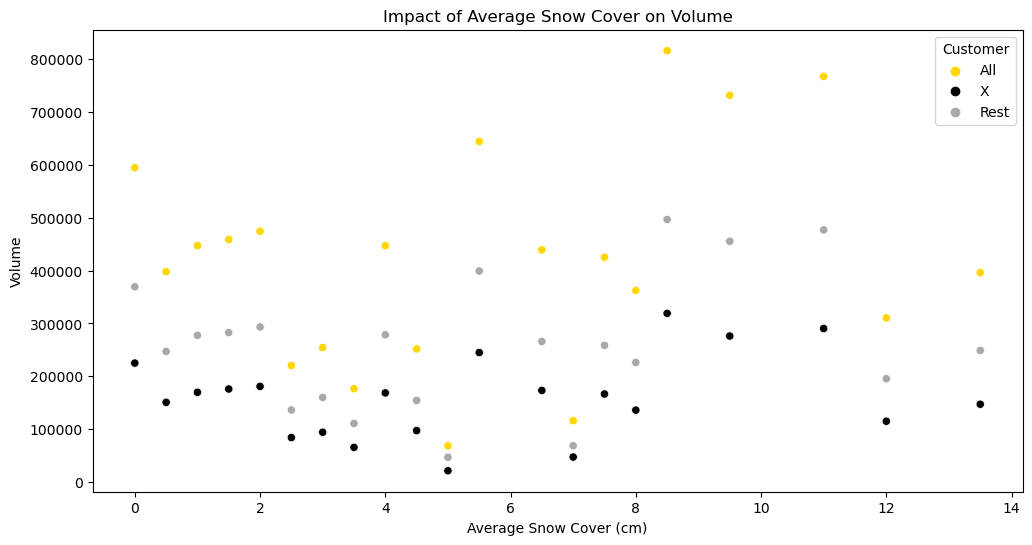

In [71]:
plot_weather_impact(combined_df, combined_df_x, combined_df_rest, 'AvgSnowCover', 'Volume', 'Average Snow Cover (cm)', 'Volume', 'Impact of Average Snow Cover on Volume')

### Analysis and conclusions:
* Greater snow cover correlates with lower shipment volumes.
* Lower shipment volumes occur for greater snow cover, which is understandable given the logistical difficulties caused by snow.
* The apparent higher shipment volume values may be due to the holiday season in December, when there is a tendency for a higher number of shipments.

### Analysis of correlation between weather conditions and shipment volume

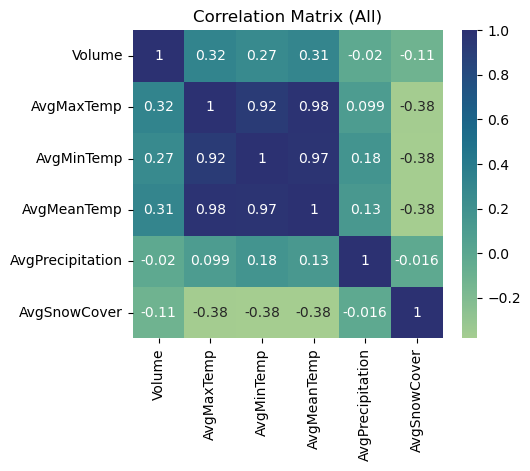

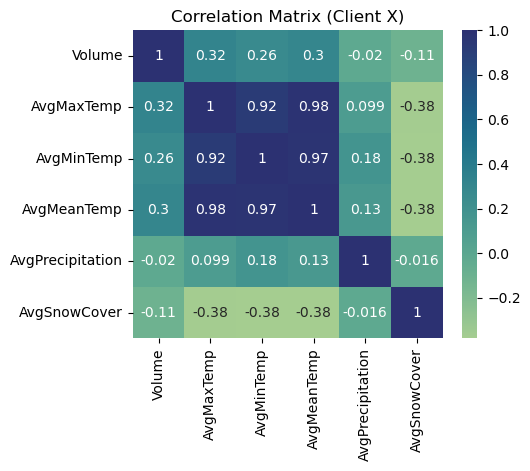

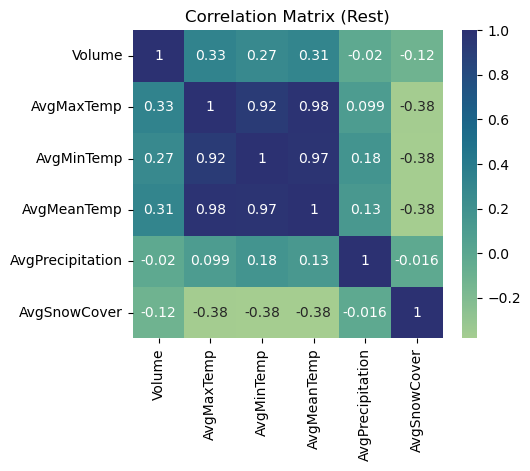

In [72]:
correlation_matrix_all = combined_df[['Volume', 'AvgMaxTemp', 'AvgMinTemp', 'AvgMeanTemp', 'AvgPrecipitation', 'AvgSnowCover']].corr()
correlation_matrix_x = combined_df_x[['Volume', 'AvgMaxTemp', 'AvgMinTemp', 'AvgMeanTemp', 'AvgPrecipitation', 'AvgSnowCover']].corr()
correlation_matrix_rest = combined_df_rest[['Volume', 'AvgMaxTemp', 'AvgMinTemp', 'AvgMeanTemp', 'AvgPrecipitation', 'AvgSnowCover']].corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix_all, annot=True, cmap='crest')
plt.title('Correlation Matrix (All)')

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix_x, annot=True, cmap='crest')
plt.title('Correlation Matrix (Client X)')

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix_rest, annot=True, cmap='crest')
plt.title('Correlation Matrix (Rest)')

plt.show()

### Conclusions:
* The highest positive correlation with the volume of shipments is found for the mean maximum temperature and mean temperature, which indicates that they may be important factors that can be used in forecasting the volume of shipments.
* The correlation with precipitation is practically neutral (-0.02), and with snow cover slightly negative (-0.11, -0.12). However, taking these factors into account can help identify days with exceptionally low activity.

## 5. Modeling <a name="modelowanie"></a>

### Selecting variables for the model training process
First, I discard data that is redundant with other variables or not useful for predictive modeling of shipment volume:

In [73]:
selected_columns = [
    'dateYear', 'dateMonth', 'dateDay', 'dateWeekDay', 'dateIsWeekend', 
    'dateIsHolidayInd', 'dateDayOfYear', 'dateWeekOfMonth', 'dateWeekOfYear', 'dateQuarter',
    'isThuHolyday', 'isFriHolyday', 'isSatHolyday', 'AvgMaxTemp', 'AvgMinTemp', 'AvgMeanTemp', 
    'AvgPrecipitation', 'AvgSnowCover'
]

In [74]:
X = combined_df[selected_columns]
y = combined_df['Volume']

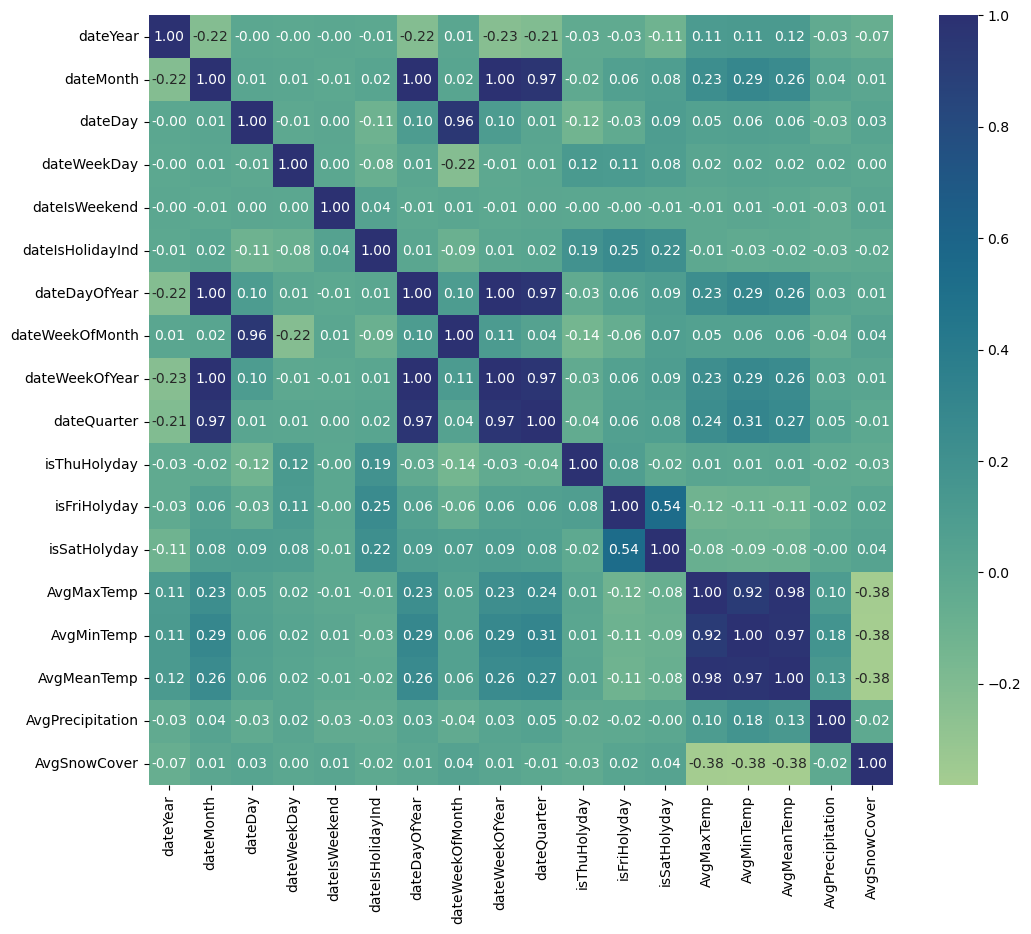

In [75]:
corr_matrix = X.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='crest')
plt.show()

In [76]:
def get_highly_correlated_features(corr_matrix, threshold=0.8):
    corr_pairs = corr_matrix.unstack()
    high_corr_pairs = corr_pairs[(abs(corr_pairs) > threshold) & (corr_pairs != 1)]
    high_corr_df = pd.DataFrame(high_corr_pairs).reset_index()
    high_corr_df.columns = ['Feature1', 'Feature2', 'Correlation']
    high_corr_df = high_corr_df.sort_values(by='Correlation', ascending=False)
    high_corr_df['sorted_pair'] = high_corr_df.apply(lambda row: tuple(sorted([row['Feature1'], row['Feature2']])), axis=1)
    high_corr_df = high_corr_df.drop_duplicates(subset='sorted_pair')
    high_corr_df = high_corr_df.drop(columns='sorted_pair')
    return high_corr_df

In [77]:
high_corr_features = get_highly_correlated_features(corr_matrix, threshold=0.5)
print("Most correlated features (correlation threshold > 0.8):")
print(high_corr_features)

Most correlated features (correlation threshold > 0.8):
           Feature1        Feature2  Correlation
9    dateWeekOfYear   dateDayOfYear     0.999546
0         dateMonth   dateDayOfYear     0.996216
1         dateMonth  dateWeekOfYear     0.995773
20      AvgMeanTemp      AvgMaxTemp     0.982468
19       AvgMinTemp     AvgMeanTemp     0.973642
2         dateMonth     dateQuarter     0.969524
12      dateQuarter   dateDayOfYear     0.966191
10   dateWeekOfYear     dateQuarter     0.965722
7   dateWeekOfMonth         dateDay     0.955137
16       AvgMaxTemp      AvgMinTemp     0.921066
14     isFriHolyday    isSatHolyday     0.537515


Based on the data correlation analysis, in the further modeling process, you can skip:
* **dateWeekOfYear**
* **dateDayOfYear**
* **AvgMeanTemp**
* **dateQuarter**
* **AvgMinTemp**
* **isSatHolyday**
* **dateWeekOfMonth**

In [78]:
features_to_remove = [
    'dateWeekOfYear',
    'dateDayOfYear',
    'dateQuarter',
    'AvgMeanTemp',
    'AvgMinTemp',
    'isSatHolyday',
    'dateWeekOfMonth',

]

X_sel = X.drop(columns=features_to_remove)

In [79]:
info(X_sel)

Info about the data frame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 973 entries, 0 to 972
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   dateYear          973 non-null    int64  
 1   dateMonth         973 non-null    int64  
 2   dateDay           973 non-null    int64  
 3   dateWeekDay       973 non-null    int64  
 4   dateIsWeekend     973 non-null    int64  
 5   dateIsHolidayInd  973 non-null    int64  
 6   isThuHolyday      973 non-null    int64  
 7   isFriHolyday      973 non-null    int64  
 8   AvgMaxTemp        973 non-null    float64
 9   AvgPrecipitation  973 non-null    float64
 10  AvgSnowCover      973 non-null    float64
dtypes: float64(3), int64(8)
memory usage: 83.7 KB


None

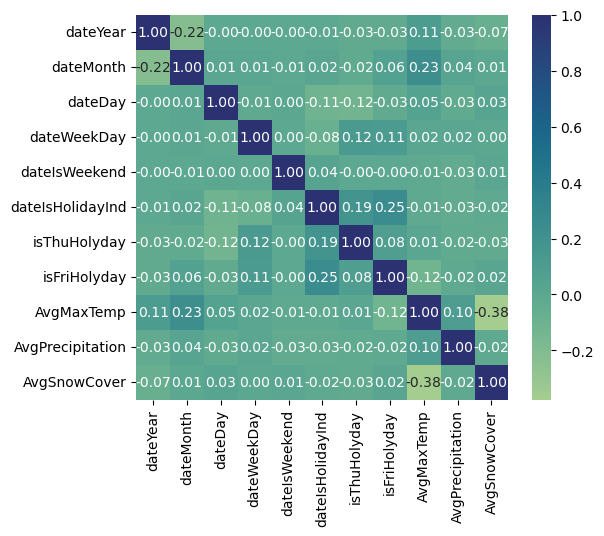

In [80]:
corr_matrix = X_sel.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='crest')
plt.show()

In [81]:
X_train, X_test, y_train, y_test = train_test_split(X_sel, y, test_size=0.25, random_state=7)

Scaling numeric data:

In [82]:
numeric_features = ['AvgMaxTemp', 'AvgPrecipitation', 'AvgSnowCover']

scaler = StandardScaler()

X_train[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

print("Scaled X_train:")
display(X_train.head())

Scaled X_train:


dateYear  dateMonth  dateDay  dateWeekDay  dateIsWeekend  \
442      2022          3       19            7              1   
871      2023          5       22            2              0   
954      2023          8       13            1              1   
113      2021          4       24            7              1   
499      2022          5       15            1              1   

     dateIsHolidayInd  isThuHolyday  isFriHolyday  AvgMaxTemp  \
442                 0             0             0   -0.599649   
871                 0             0             0    0.802564   
954                 0             0             0    1.627086   
113                 0             0             0   -0.331810   
499                 0             0             0    0.602998   

     AvgPrecipitation  AvgSnowCover  
442         -0.436524     -0.242441  
871         -0.436524     -0.242441  
954         -0.436524     -0.242441  
113         -0.436524     -0.242441  
499         -0.436524     -0.242441

### Choosing the best model with the right parameters

#### Creating pipelines for 5 different regressors to find the best one.
Regressors:
* **Decision Tree Regressor**
* **Linear Regression**
* **Random Forest Regressor**
* **XGBRegressor**
* **KNeighbors Regressor**

In [83]:
pipeline_dt=Pipeline([("scalar1",StandardScaler()),
                     ("dt",DecisionTreeRegressor())])

pipeline_lr=Pipeline([("scalar2",StandardScaler()),
                     ("lr",LinearRegression())])

pipeline_rf=Pipeline([("scalar3",StandardScaler()),
                     ("rf",RandomForestRegressor())])

pipeline_xgb=Pipeline([("scalar4",StandardScaler()),
                     ("xgb",XGBRegressor())])

pipeline_kn=Pipeline([("scalar5",StandardScaler()),
                     ("kn",KNeighborsRegressor())])

#### Defining parameters for each model

In [84]:
param_grid_dt = {
    'dt__max_depth': [3, 5, 10, None],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4]
}

param_grid_lr = {
    'lr__fit_intercept': [True, False]
}

param_grid_rf = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [None, 10, 20],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}


param_grid_xgb = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.01, 0.1, 0.2],
    'xgb__max_depth': [3, 5, 10],
    'xgb__subsample': [0.6, 0.8, 1.0]
}

param_grid_kn = {
    'kn__n_neighbors': [3, 5, 10],
    'kn__weights': ['uniform', 'distance'],
    'kn__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

grid_search_lr = GridSearchCV(estimator=pipeline_lr, param_grid=param_grid_lr, scoring='neg_root_mean_squared_error', cv=10)
grid_search_dt = GridSearchCV(estimator=pipeline_dt, param_grid=param_grid_dt, scoring='neg_root_mean_squared_error', cv=10)
grid_search_rf = GridSearchCV(estimator=pipeline_rf, param_grid=param_grid_rf, scoring='neg_root_mean_squared_error', cv=10)
grid_search_kn = GridSearchCV(estimator=pipeline_kn, param_grid=param_grid_kn, scoring='neg_root_mean_squared_error', cv=10)
grid_search_xgb = GridSearchCV(estimator=pipeline_xgb, param_grid=param_grid_xgb, scoring='neg_root_mean_squared_error', cv=10)

grid_searches = [grid_search_dt, grid_search_lr, grid_search_rf, grid_search_xgb, grid_search_kn]

grid_dict = {0: "DecisionTree", 1: "LinearRegression", 2: "RandomForest", 3: "XGBRegressor", 4: "KNeighbors"}

In [85]:
for idx, gs in enumerate(grid_searches):
    gs.fit(X_train, y_train)
    print(f"{grid_dict[idx]} best params: {gs.best_params_}")
    print(f"{grid_dict[idx]} best score: {-gs.best_score_}")

DecisionTree best params: {'dt__max_depth': None, 'dt__min_samples_leaf': 1, 'dt__min_samples_split': 10}
DecisionTree best score: 186245.34053360097
LinearRegression best params: {'lr__fit_intercept': True}
LinearRegression best score: 225881.30692869253
RandomForest best params: {'rf__max_depth': None, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 2, 'rf__n_estimators': 200}
RandomForest best score: 150010.8004436432
XGBRegressor best params: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}
XGBRegressor best score: 99119.28015703599
KNeighbors best params: {'kn__algorithm': 'auto', 'kn__n_neighbors': 3, 'kn__weights': 'distance'}
KNeighbors best score: 183510.17624733265


The best result was obtained for **XGBRegressor** with parameters: {'xgb__learning_rate': 0.2, 'xgb__max_depth': 3, 'xgb__n_estimators': 200, 'xgb__subsample': 0.8}.

## 6. Evaluation and conclusions <a name="ewaluacja"></a>

### Evaluation of the XGBRegressor model

In [86]:
best_xgb_params = {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
xgb_model = XGBRegressor(**best_xgb_params)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f'MAE: {mae}')
print(f'RMSE: {rmse}')

MAE: 74198.77597161685
RMSE: 97654.37179169404


The high standard deviation of the shipment volume (87922.90) indicates a large variability in the data, so the MAE value may be caused by single large forecasting errors that have a significant impact on the total result (also indicated by the RMSE being larger than the MAE). The comparison of the actual shipment volume with the forecasted values ​​can be better illustrated with a graph:

In [87]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_test, mode='lines', name='Actual Volume', line=dict(color='black')))

fig.add_trace(go.Scatter(x=list(range(len(y_test))), y=y_pred, mode='lines', name='Predicted Volume', line=dict(dash='dash', color='gold')))

fig.update_layout(
    title='Actual vs Predicted Volume',
    xaxis_title='Sample',
    yaxis_title='Volume',
    width=2000,
    height=600,
    plot_bgcolor='white',
    paper_bgcolor='white',
    xaxis=dict(
        showgrid=True,
        gridcolor='lightgray'
    ),
    yaxis=dict(
        showgrid=True,
        gridcolor='lightgray'
    )
)

fig.show()

The graph shows that the predicted values are close to the actual values, which indicates good model performance. Single large errors are visible, especially when there is a large decrease or increase in the number of shipments.

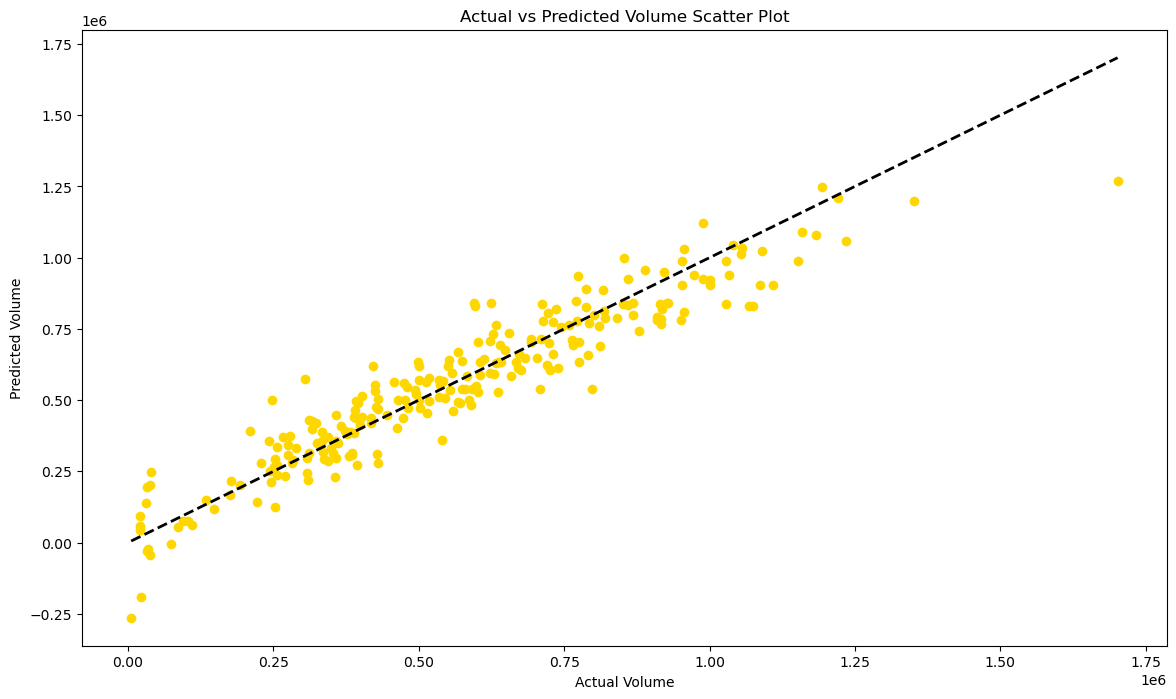

In [88]:
plt.figure(figsize=(14, 8))
plt.scatter(y_test, y_pred, color='gold')
plt.xlabel('Actual Volume')
plt.ylabel('Predicted Volume')
plt.title('Actual vs Predicted Volume Scatter Plot')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='black', linestyle='--', lw=2)
plt.show()

Points near the diagonal line suggest good agreement between actual and forecast values. There are some outliers, especially at the beginning and end of the value range.

### Conclusions
* The best model for predicting volume turned out to be **XGBoost**, with MAE values: 74198.776 and RMSE: 97654.372. Considering the volume statistics, these results are satisfactory and suggest that the model does a relatively good job of predicting volume.

### Suggestions for future model improvements:
* Further feature engineering, such as creating new variables from existing data (e.g. feature interactions), could help better capture trends in the data.
* Continuous hyperparameter optimization using techniques such as GridSearchCVu.
* Regularly monitoring model performance and adjusting it based on new data.